In [ ]:
!pip install git+https://github.com/miladmozafari/predify.git

  Cloning https://github.com/miladmozafari/predify.git to /tmp/pip-req-build-4xlcxg6p
  Running command git clone --filter=blob:none --quiet https://github.com/miladmozafari/predify.git /tmp/pip-req-build-4xlcxg6p
  Resolved https://github.com/miladmozafari/predify.git to commit eca7a741048fdeb29451629cb67e9c3458a8e949
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu

Predictive coding is implemented in this code by adding extra components called "predictive coders" or "pcoders" to specific layers of the CNN model. Here's a concise explanation of the implementation and training process:

1. Configuration:
   - A configuration file (`mnist_config.toml`) is created to specify the predictive coders.
   - The configuration defines two pcoders, one for `features[1]` and another for `features[3]` layers of the model.
   - Each pcoder specifies the associated module, the predictor (a convolutional transpose layer), and hyperparameters (feedforward, feedback, and pc).

2. Model Modification:
   - The `predify` function is called with the model and the configuration file path as arguments.
   - The function modifies the model by adding the specified pcoders to the corresponding layers based on the configuration.

3. Training Process:
   - The modified model is trained using the `train` function for a specified number of epochs (5 in this case).
   - For each epoch and each batch of training data:
     - Forward propagation is performed to compute the model's output.
     - The loss is calculated using the cross-entropy loss function.
     - Backward propagation is performed to compute the gradients.
     - The optimizer (Adam) updates the model's parameters based on the gradients.
   - The training progress is printed every 100 batches, showing the epoch, batch, and loss information.

4. Evaluation:
   - After training, the model is evaluated using the `test` function on the test dataset.
   - The test loss and accuracy are calculated by comparing the model's predictions with the ground truth labels.
   - The test loss and accuracy are printed.

The predictive coding aspect comes into play during the forward and backward propagation steps. The added pcoders make predictions based on the activations of the associated layers, and the differences between the predictions and the actual activations are used to update the model's parameters during training.

The overall structure of the training process remains similar to a standard CNN training pipeline, with the addition of the predictive coding components. The model is trained using the training dataset, and the performance is evaluated on the test dataset.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from predify import predify

# Define a basic CNN for MNIST
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Set up data loaders
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BasicCNN().to(device)

# Create a config file for Predify
config = """
name = "PredictiveMNIST"
input_size = [1, 28, 28]
gradient_scaling = true
shared_hyperparameters = false

[[pcoders]]
module = "features[1]"
predictor = "ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))"
hyperparameters = {feedforward=0.3, feedback=0.3, pc=0.01}

[[pcoders]]
module = "features[3]"
predictor = "ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))"
hyperparameters = {feedforward=0.3, feedback=0.3, pc=0.01}
"""

# Save the config to a file
with open('mnist_config.toml', 'w') as f:
    f.write(config)

# Apply Predify to the model
predify(model, 'mnist_config.toml')

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
def train(epochs):
    for epoch in range(epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

# Evaluation function
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

# Train and evaluate the model
train(epochs=5)
test()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 21379995.99it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 633236.94it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4596806.91it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8470666.42it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1/5, Batch 0/938, Loss: 2.3066
Epoch 1/5, Batch 100/938, Loss: 0.2064
Epoch 1/5, Batch 200/938, Loss: 0.1760
Epoch 1/5, Batch 300/938, Loss: 0.0302
Epoch 1/5, Batch 400/938, Loss: 0.0946
Epoch 1/5, Batch 500/938, Loss: 0.0064
Epoch 1/5, Batch 600/938, Loss: 0.0319
Epoch 1/5, Batch 700/938, Loss: 0.0468
Epoch 1/5, Batch 800/938, Loss: 0.0456
Epoch 1/5, Batch 900/938, Loss: 0.0095
Epoch 2/5, Batch 0/938, Loss: 0.0042
Epoch 2/5, Batch 100/938, Loss: 0.0096
Epoch 2/5, Batch 200/938, Loss: 0.0176
Epoch 2/5, Batch 300/938, Loss: 0.0060
Epoch 2/5, Batch 400/938, Loss: 0.0204
Epoch 2/5, Batch 500/938, Loss: 0.0744
Epoch 2/5, Batch 600/938, Loss: 0.0243
Epoch 2/5, Batch 700/938, Loss: 0.0160
Epoch 2/5, Batch 800/938, Loss: 0.1254
Epoch 2/5, Batch 900/938, Loss: 0.0106
Epoch 3/5, Batch 0/938, Loss: 0.0265
Epoch 3/5, Batch 100/938, Loss: 0.0047
Epoch 3/5, Batch 200/938, Loss: 0.0197
Epoch 3/5, Batch 300/938, Loss: 0.

  Cloning https://github.com/miladmozafari/predify.git to /tmp/pip-req-build-kz9ybmp6
  Running command git clone --filter=blob:none --quiet https://github.com/miladmozafari/predify.git /tmp/pip-req-build-kz9ybmp6
  Resolved https://github.com/miladmozafari/predify.git to commit eca7a741048fdeb29451629cb67e9c3458a8e949
  Preparing metadata (setup.py) ... done
Initial Model Information:
Model Architecture:
BasicCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=12544, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

Layer Information:
features.0:
  Type: Conv2d
  Input shape: torch.Size([1

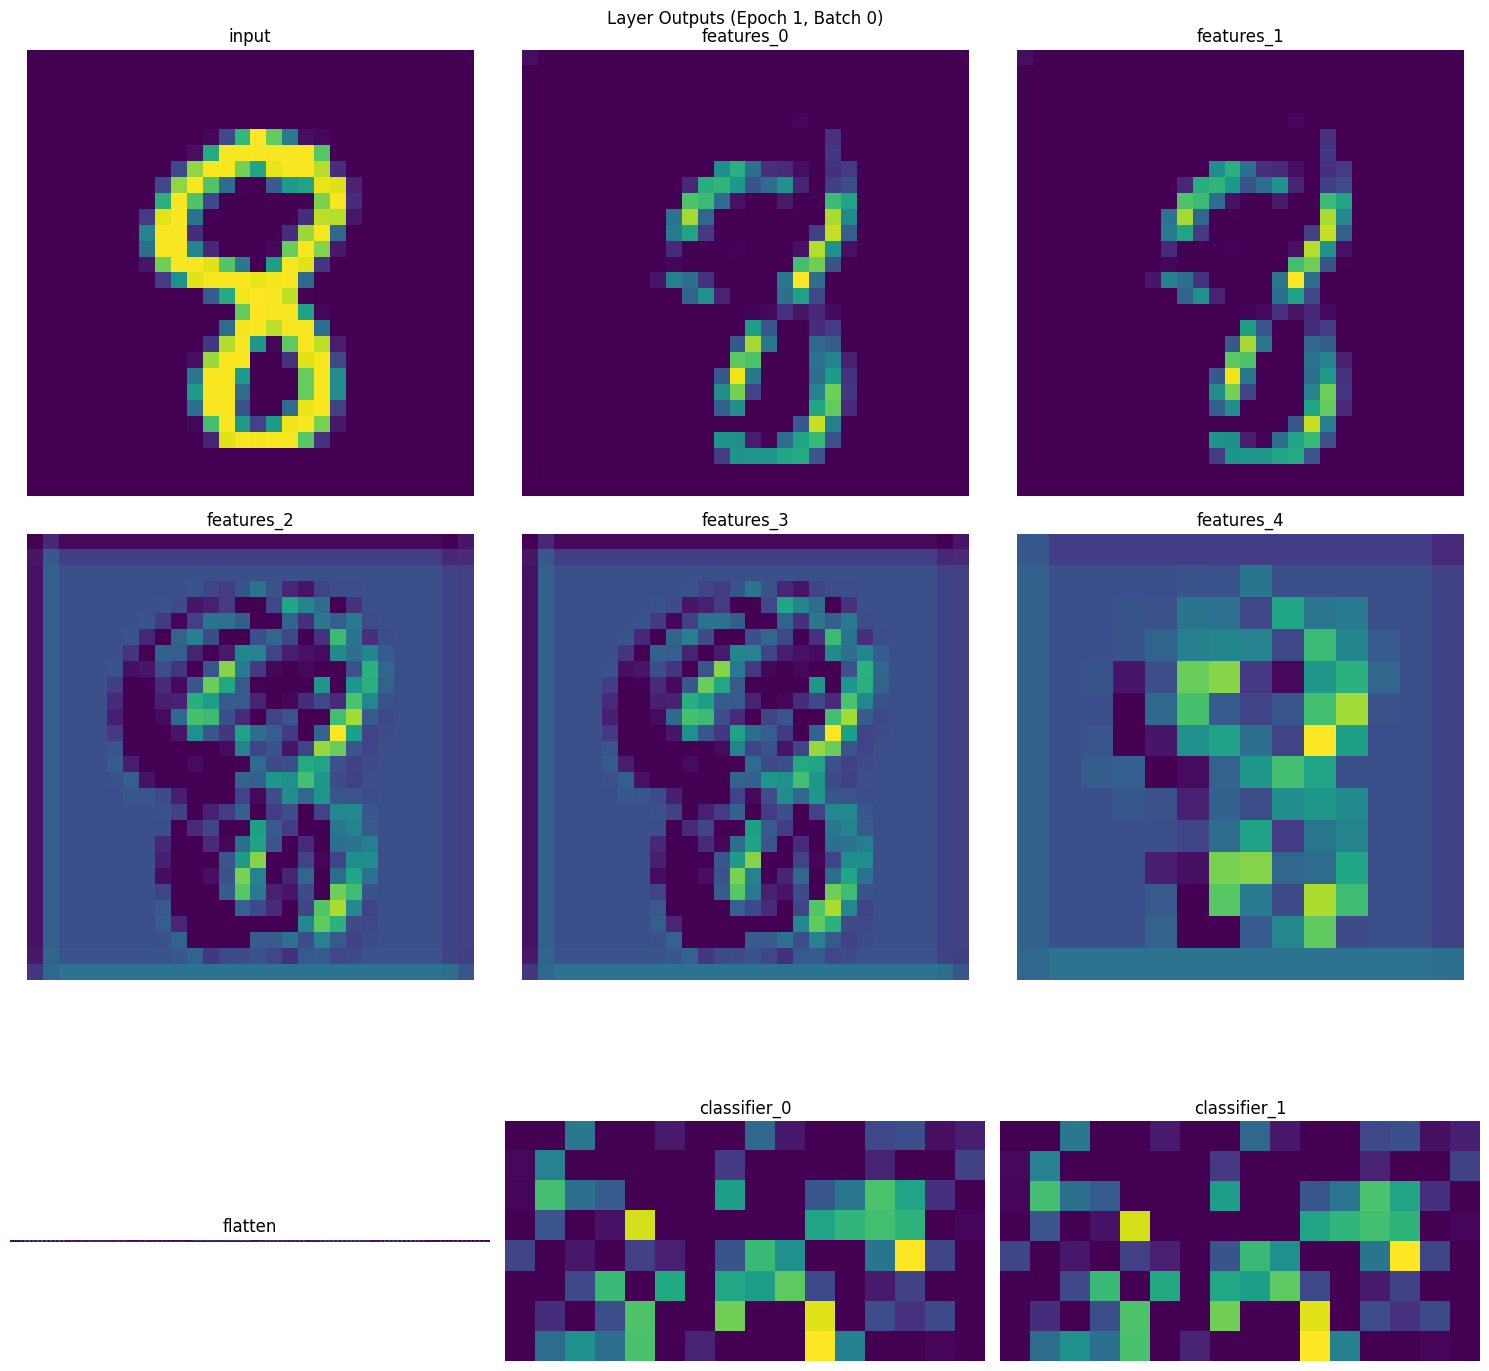


Analyzing pcoder layers:
Epoch 1/5, Batch 100/938, Loss: 0.0902


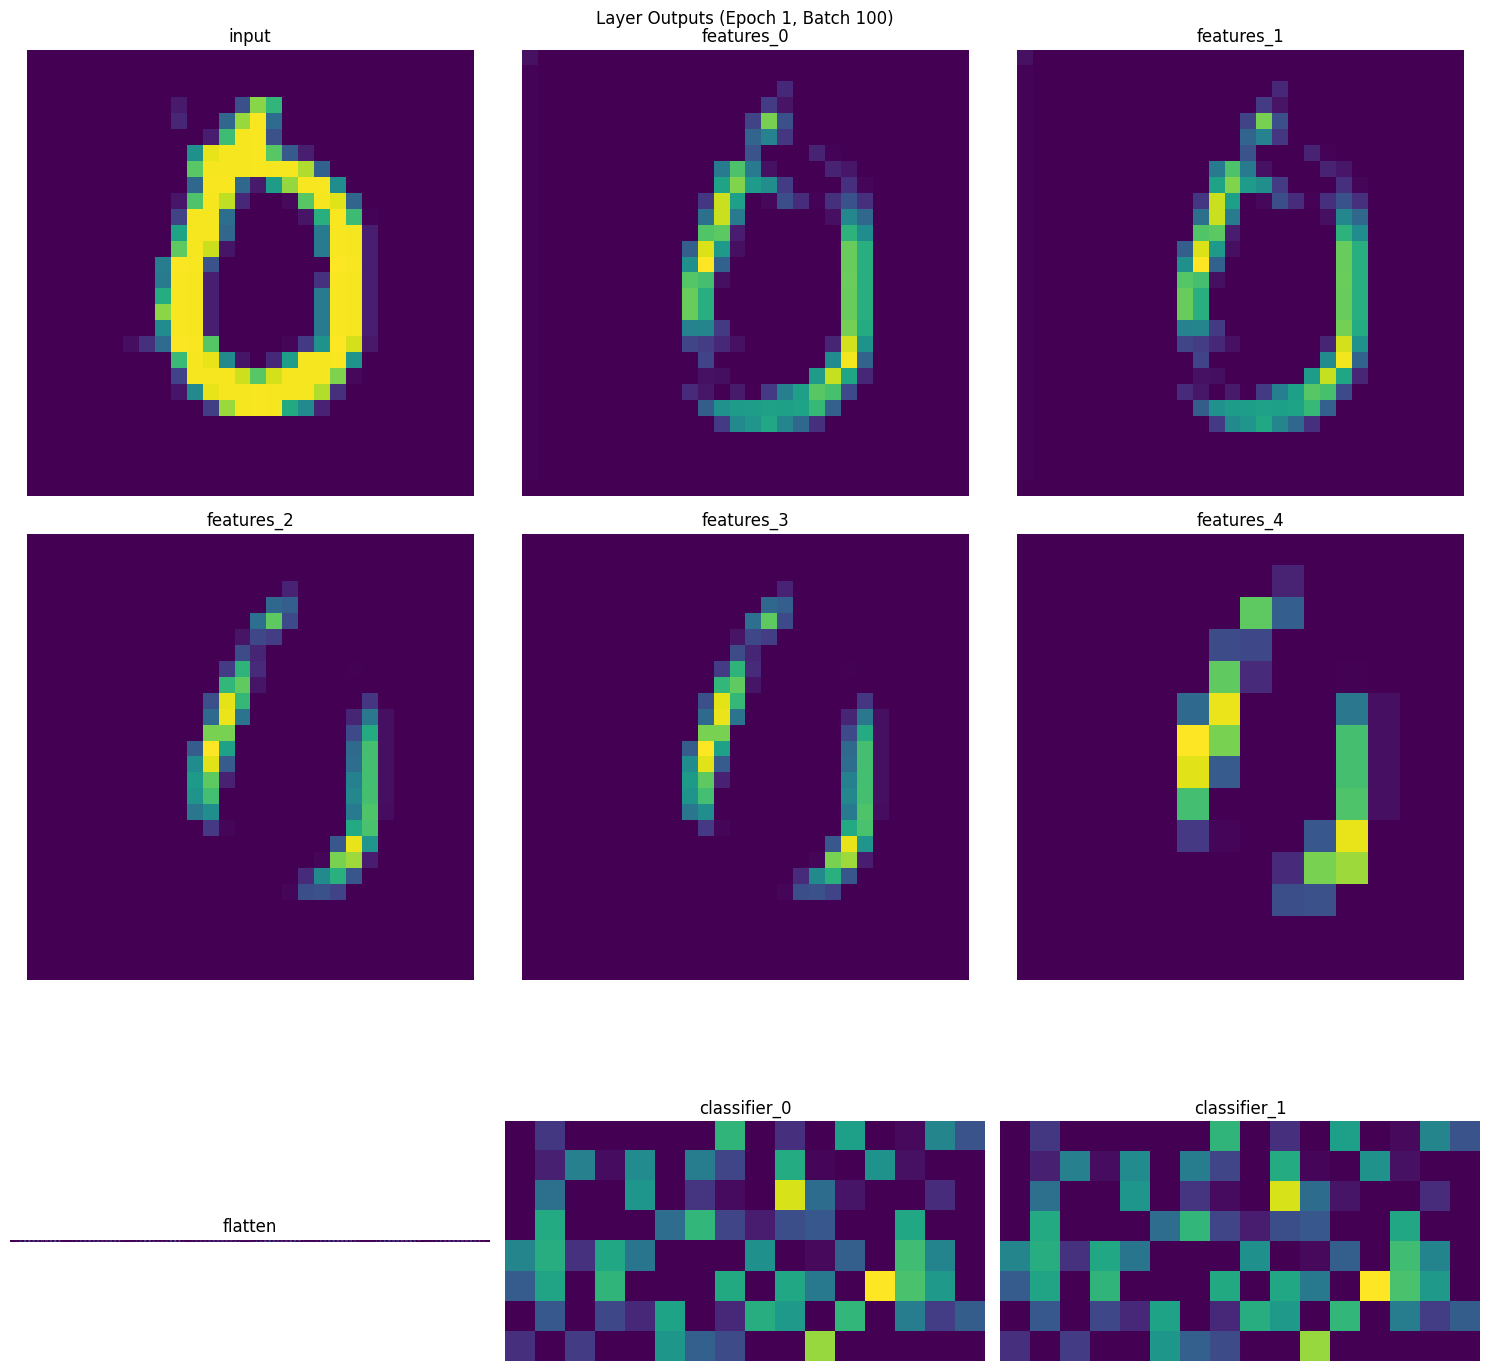


Analyzing pcoder layers:
Epoch 1/5, Batch 200/938, Loss: 0.1723


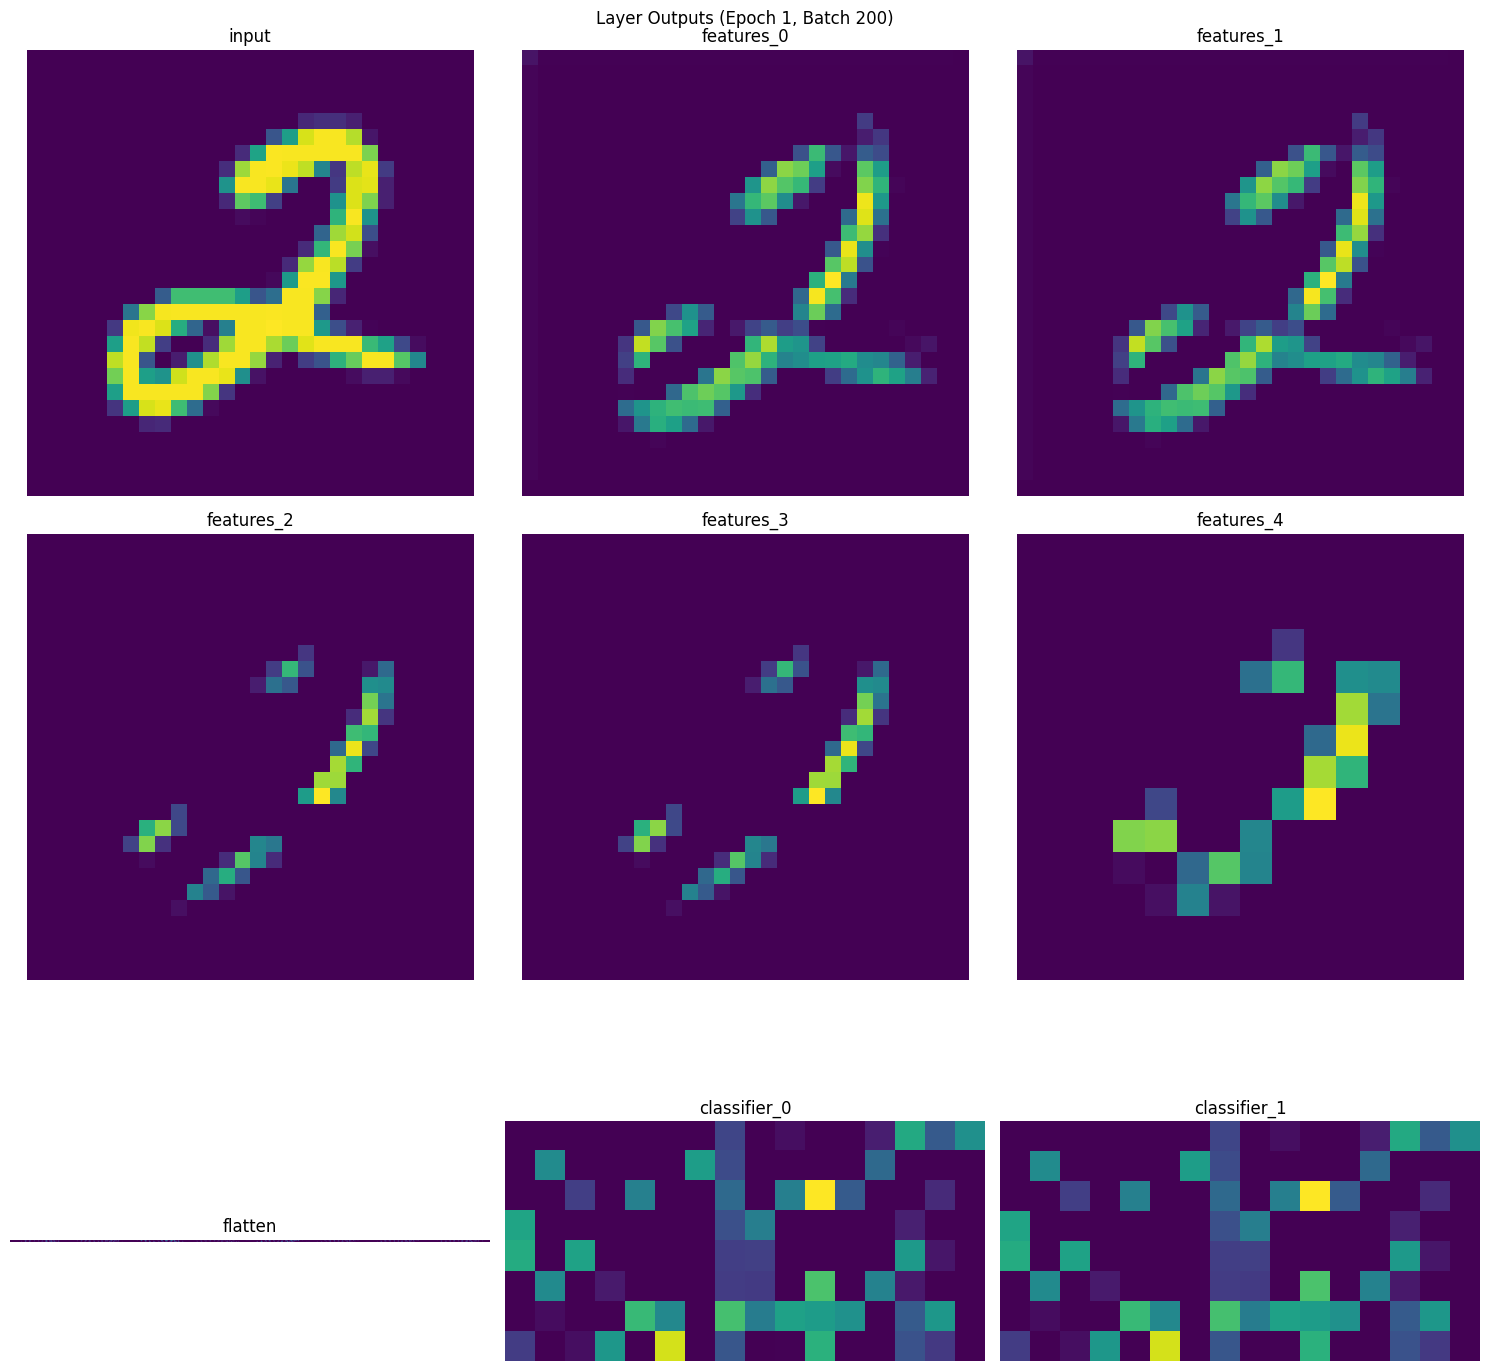


Analyzing pcoder layers:
Epoch 1/5, Batch 300/938, Loss: 0.0418


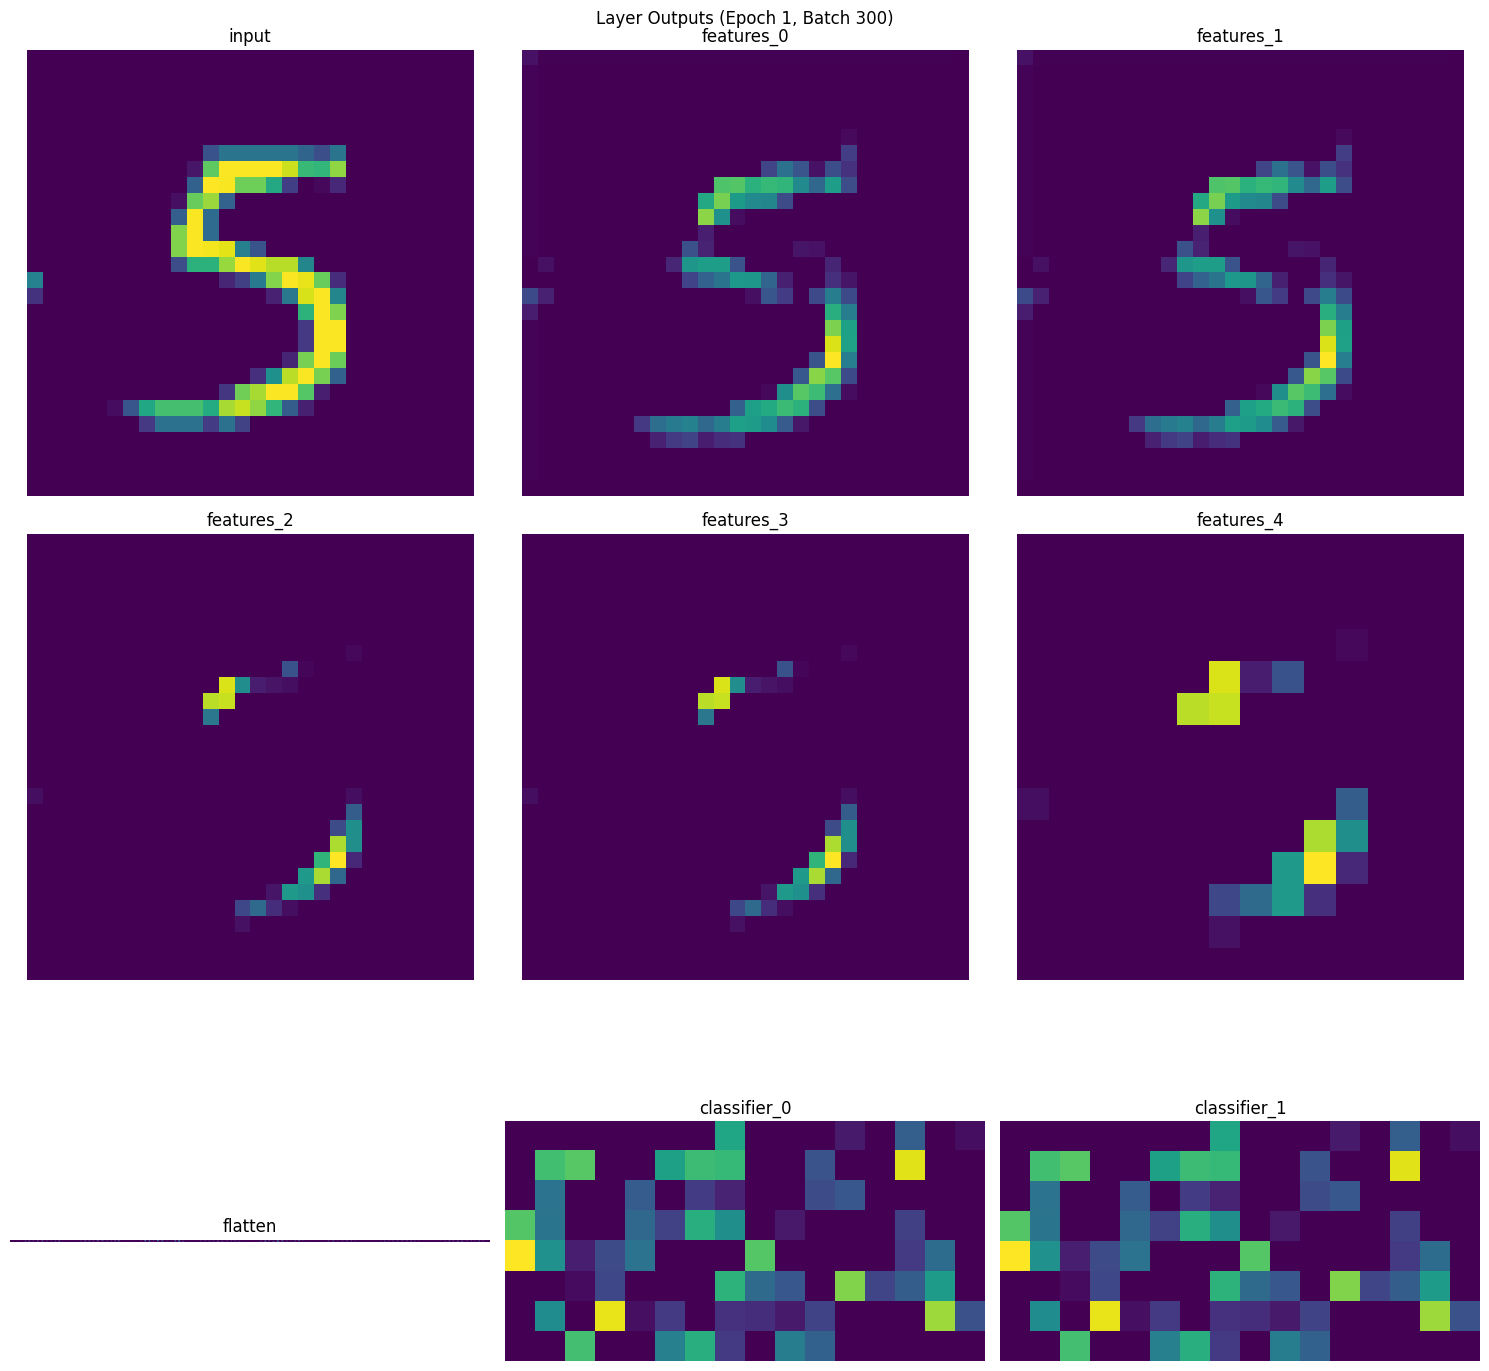


Analyzing pcoder layers:
Epoch 1/5, Batch 400/938, Loss: 0.0092


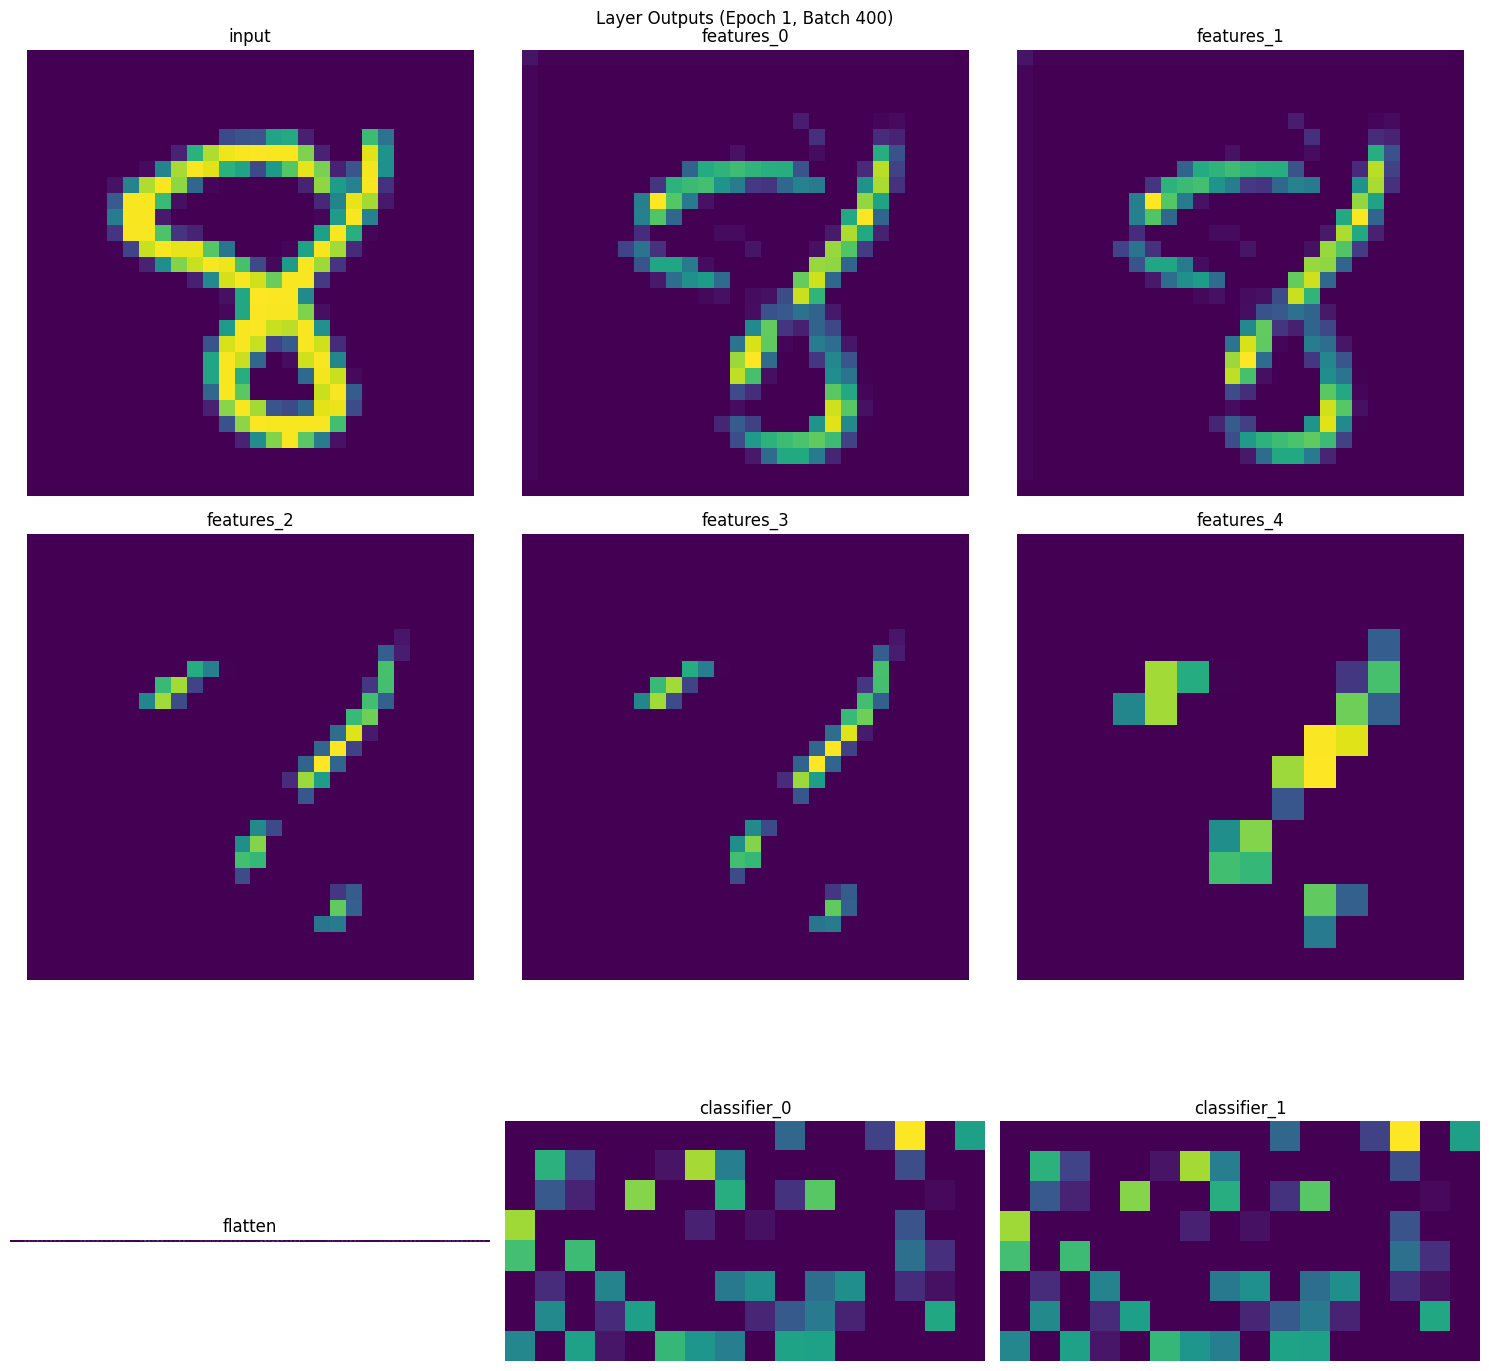


Analyzing pcoder layers:
Epoch 1/5, Batch 500/938, Loss: 0.0930


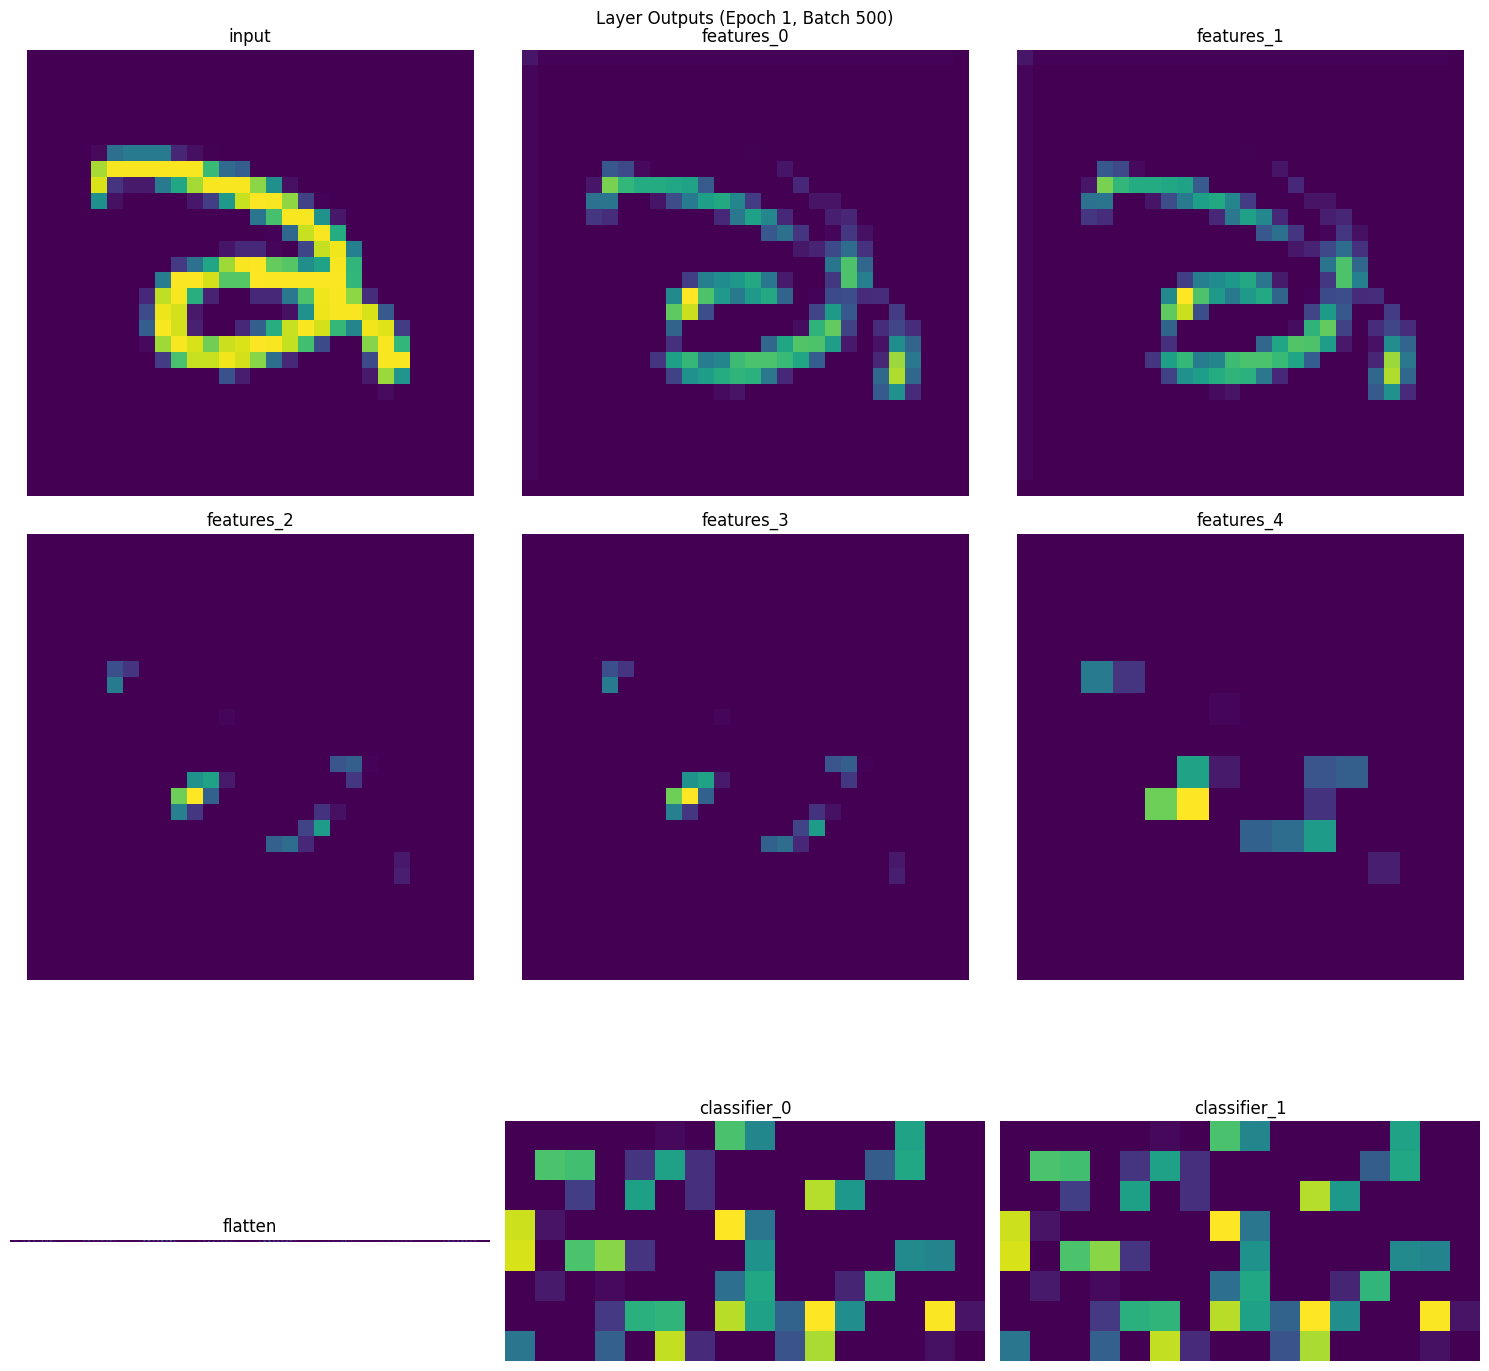


Analyzing pcoder layers:
Epoch 1/5, Batch 600/938, Loss: 0.1560


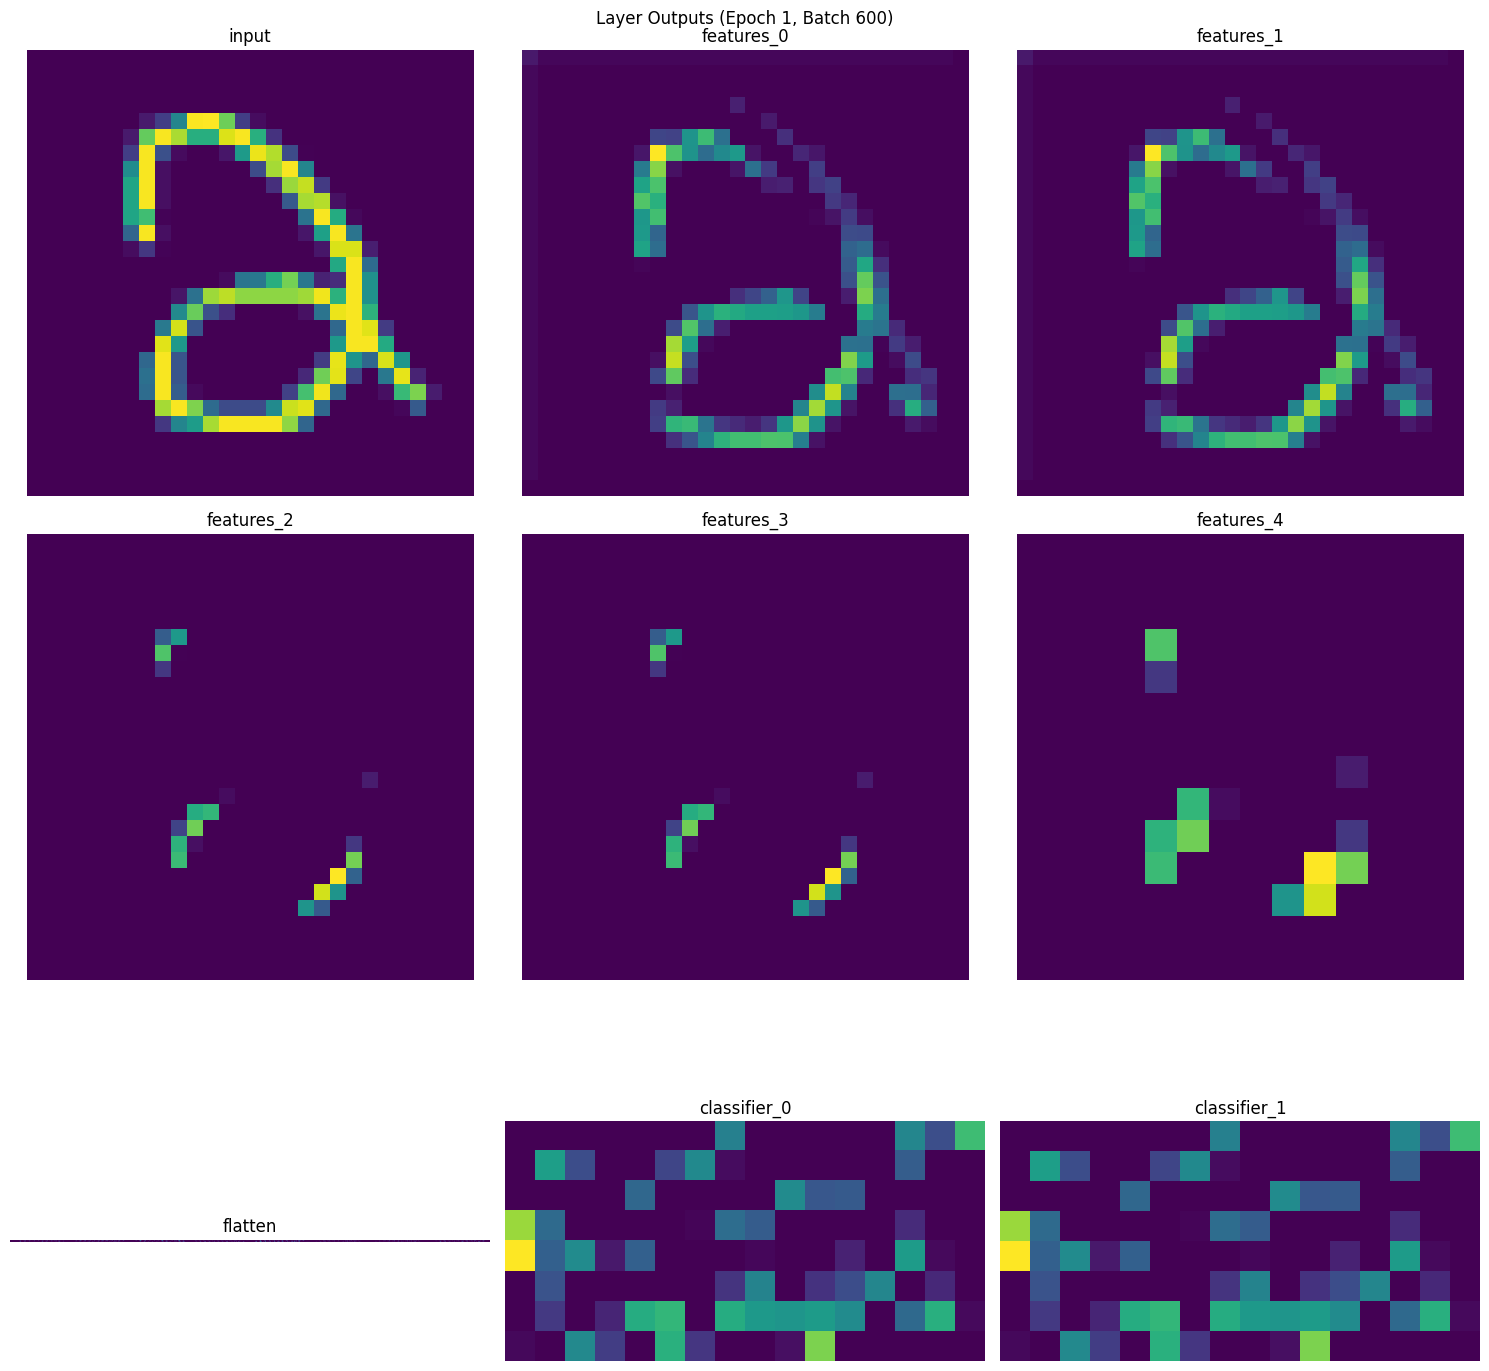


Analyzing pcoder layers:
Epoch 1/5, Batch 700/938, Loss: 0.1069


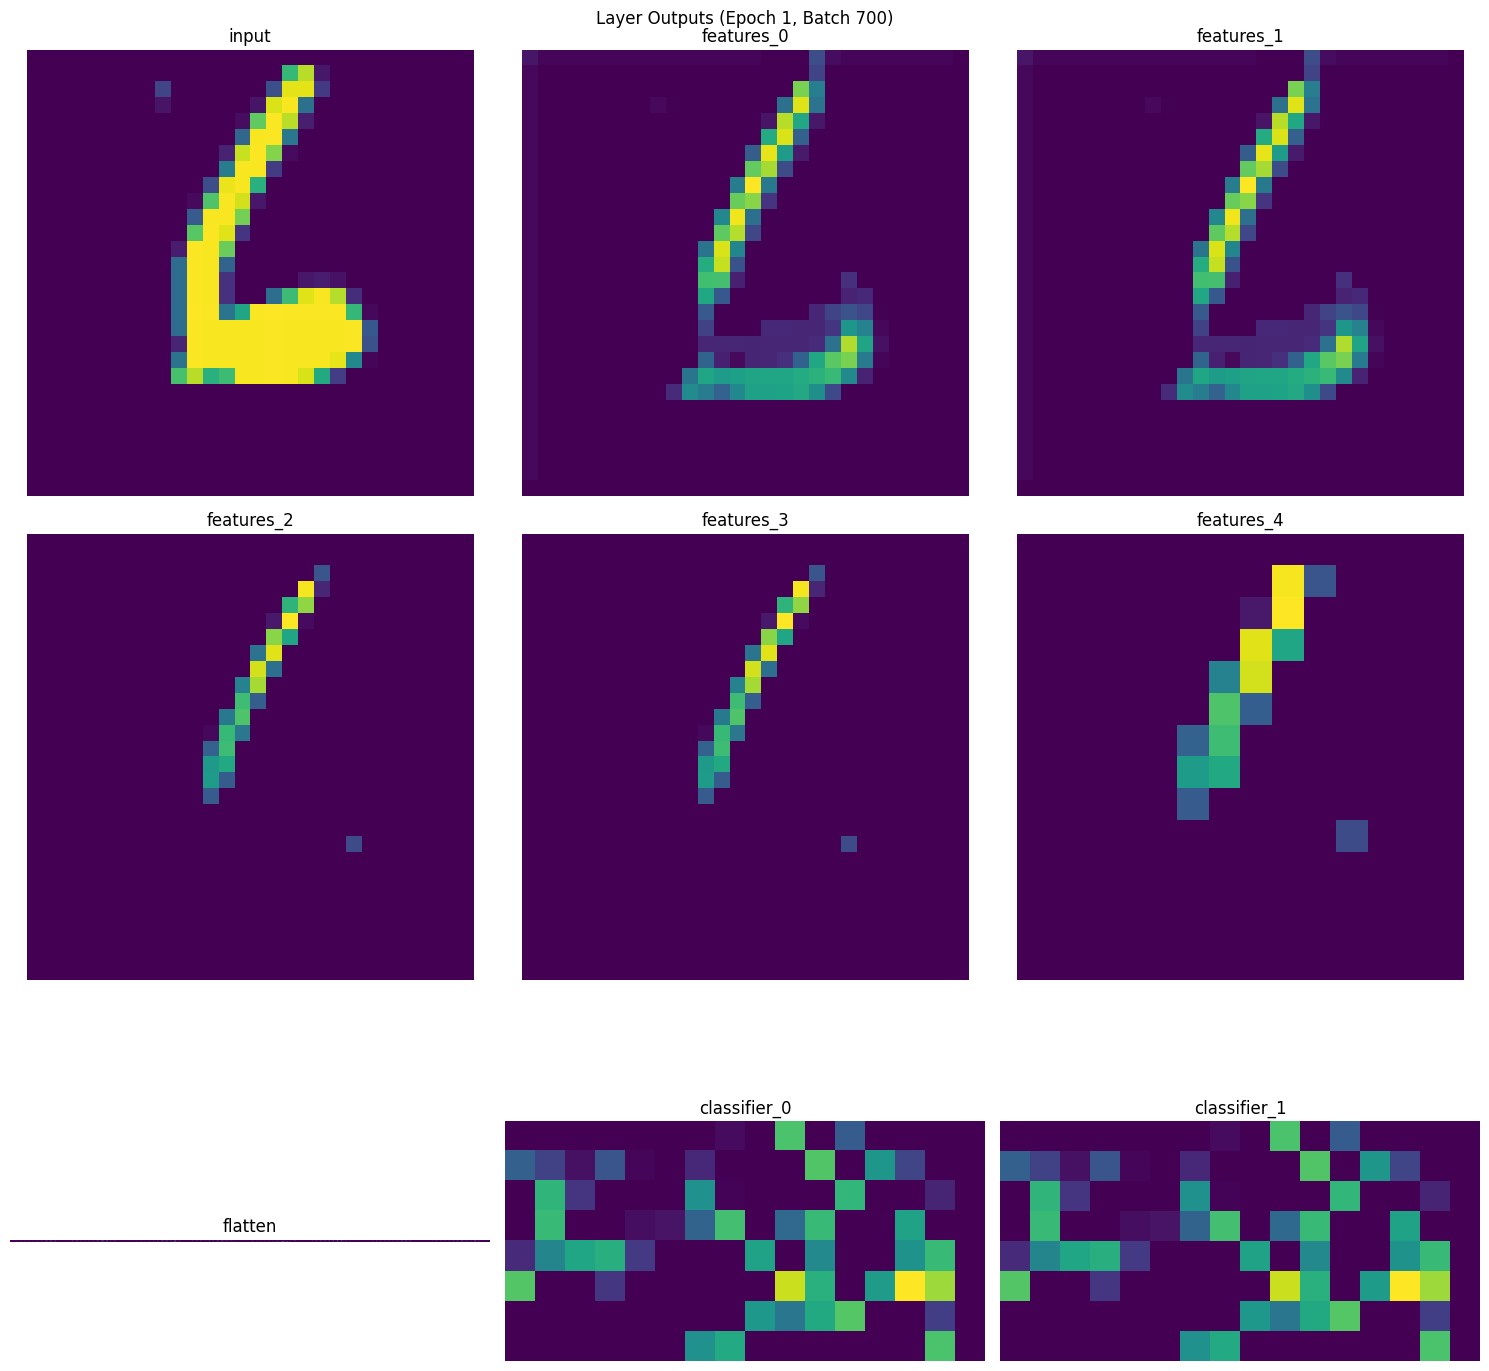


Analyzing pcoder layers:
Epoch 1/5, Batch 800/938, Loss: 0.0025


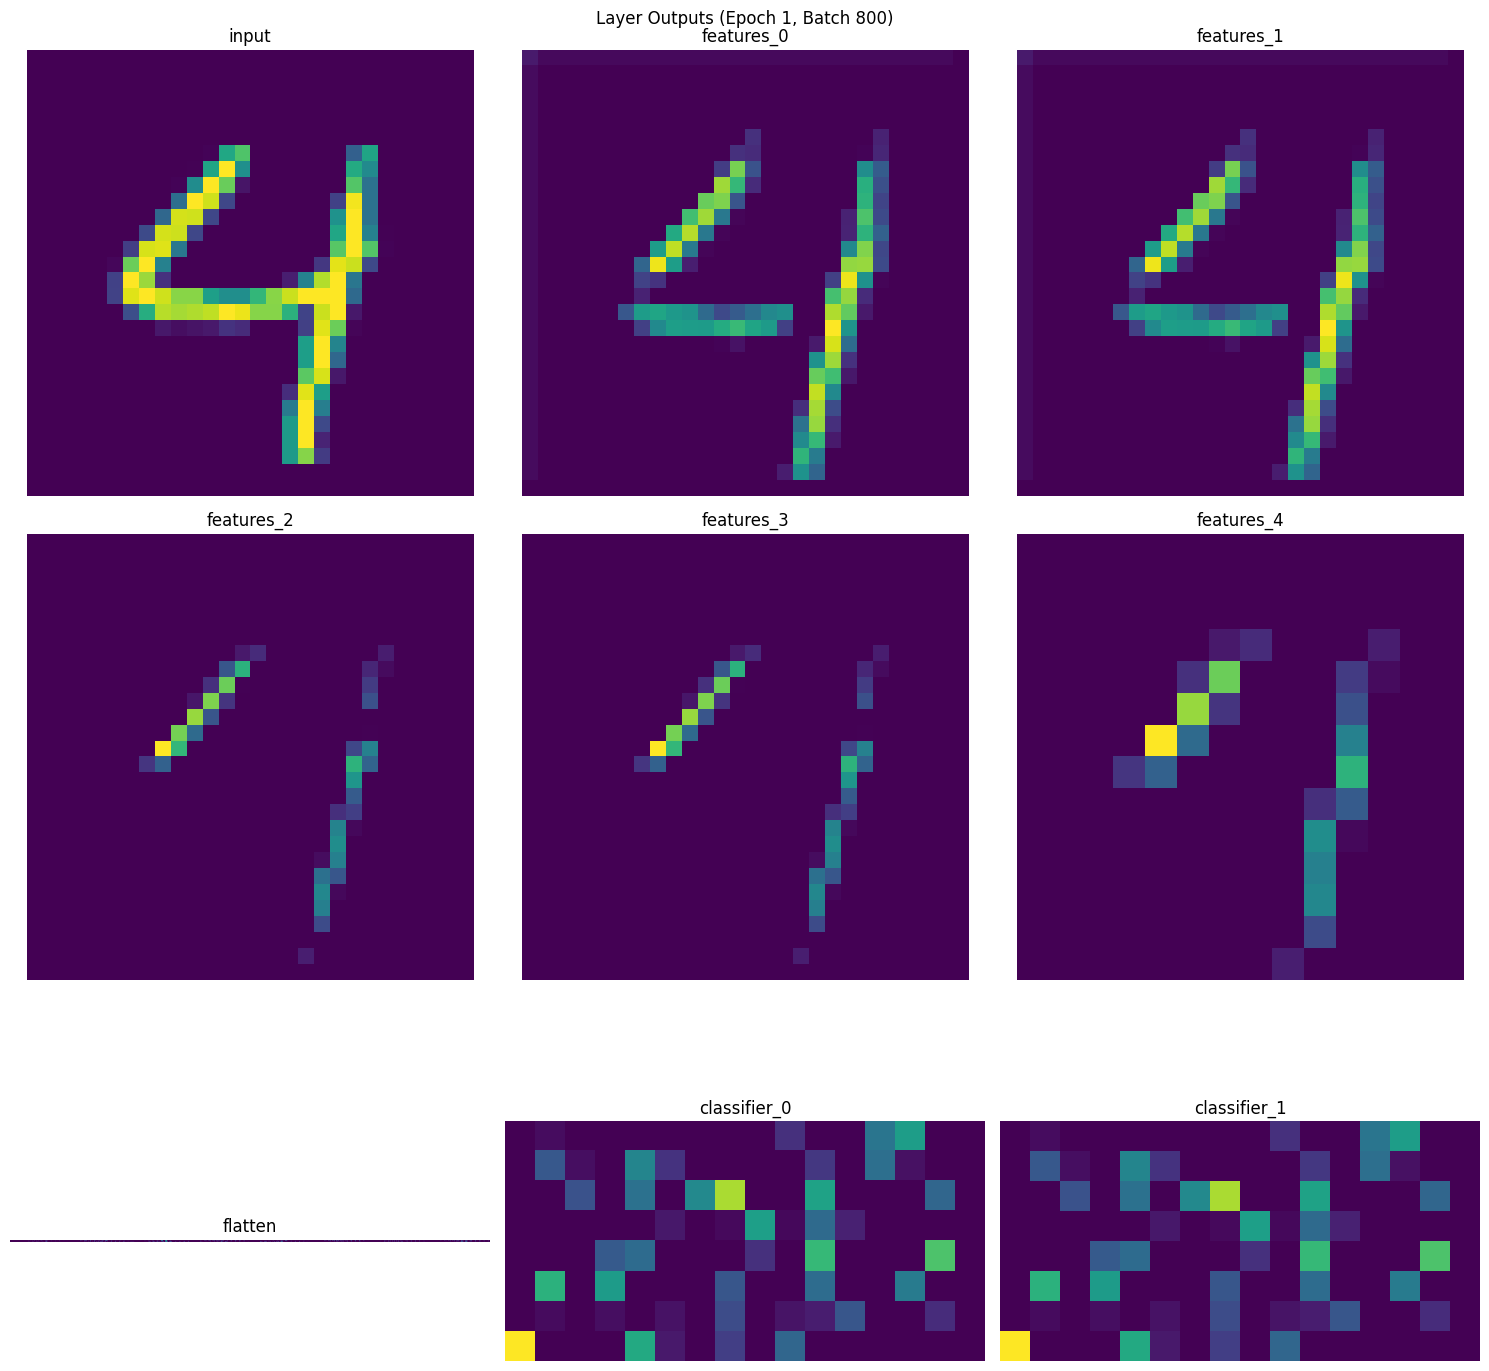


Analyzing pcoder layers:
Epoch 1/5, Batch 900/938, Loss: 0.0772


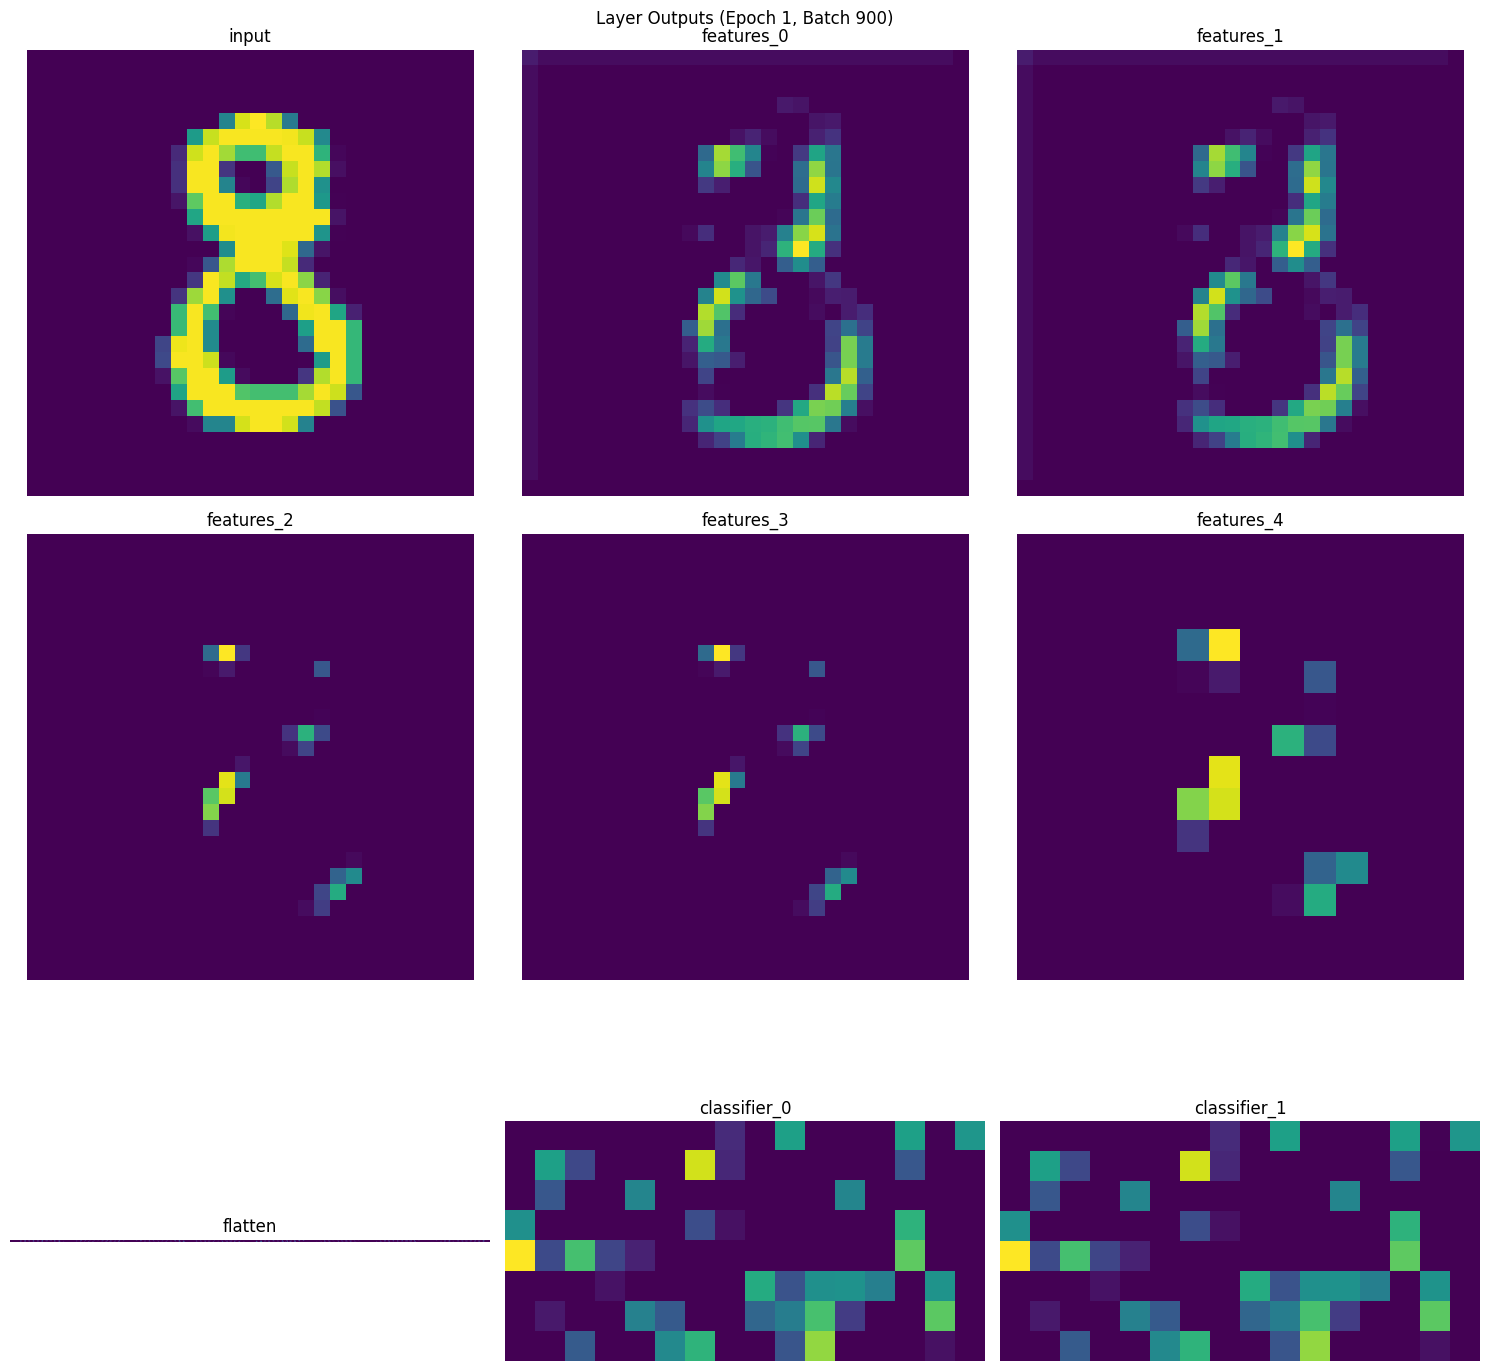


Analyzing pcoder layers:
Epoch 2/5, Batch 0/938, Loss: 0.0205


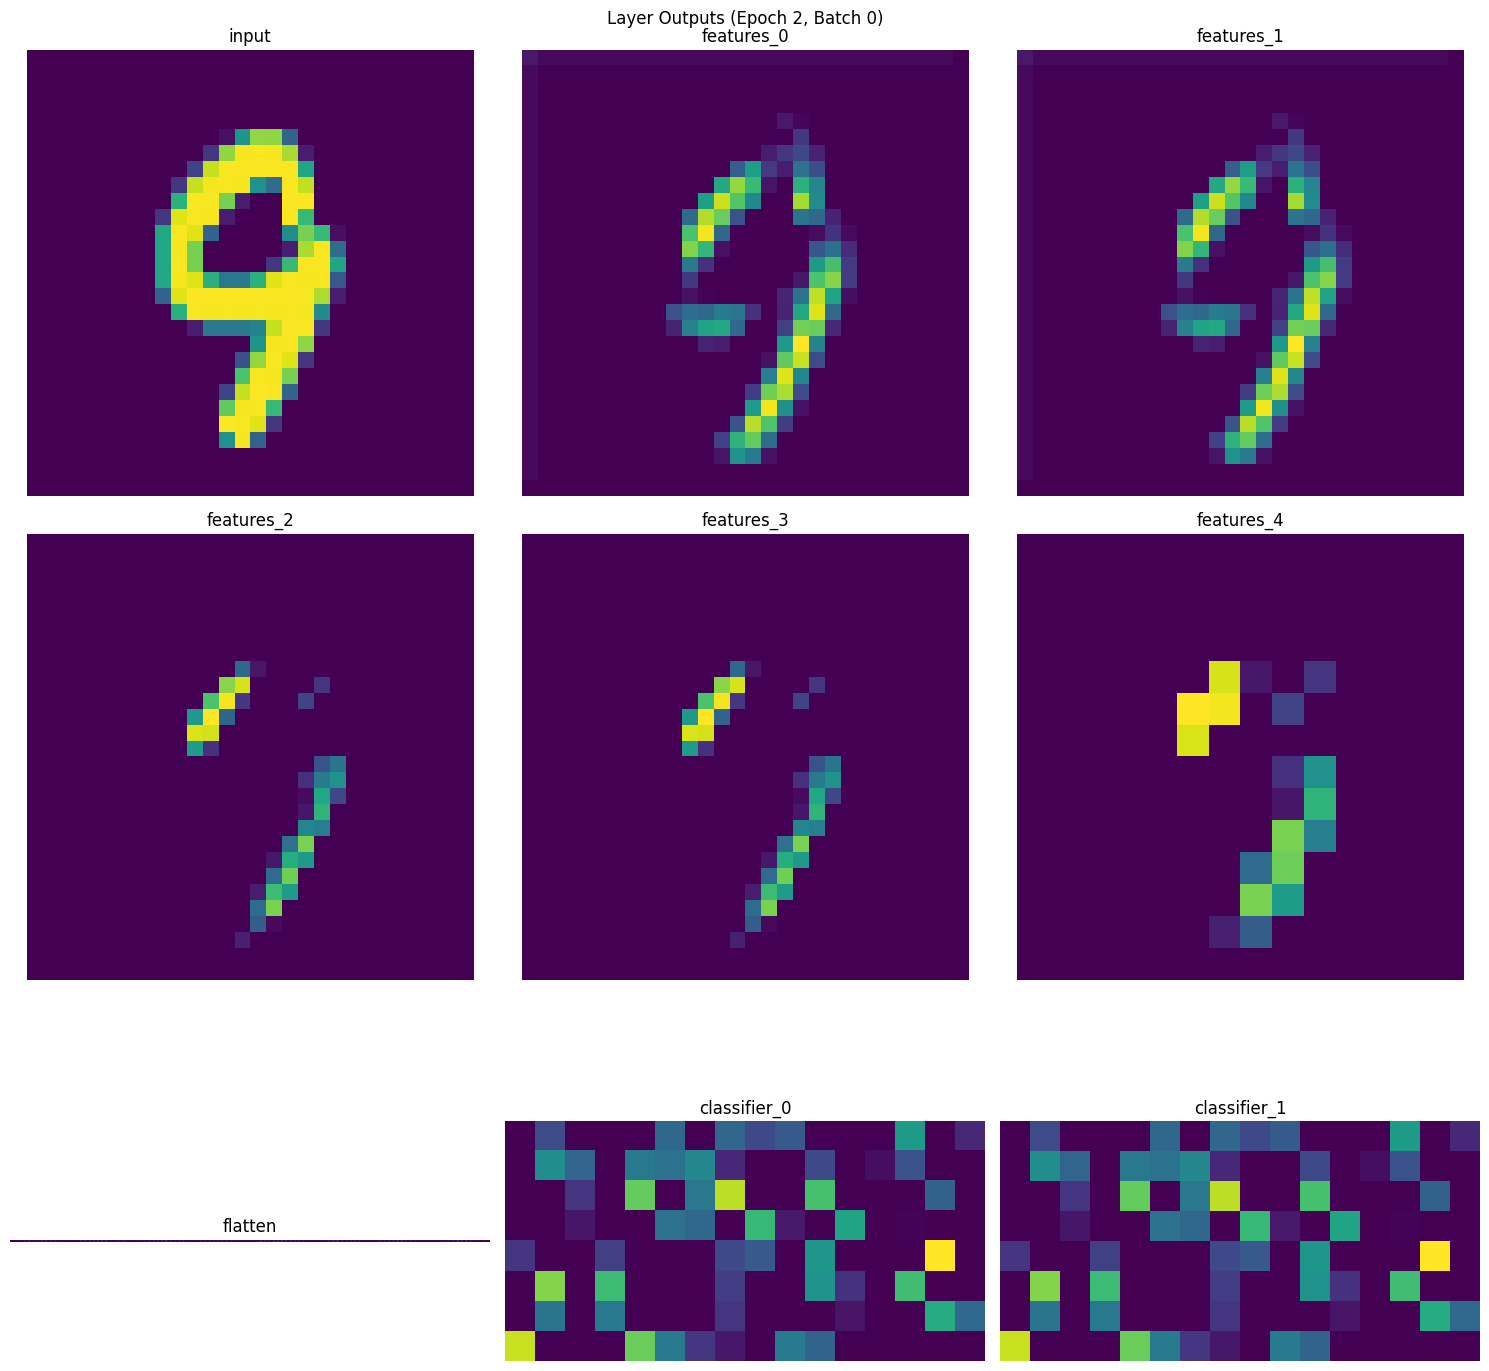


Analyzing pcoder layers:
Epoch 2/5, Batch 100/938, Loss: 0.0036


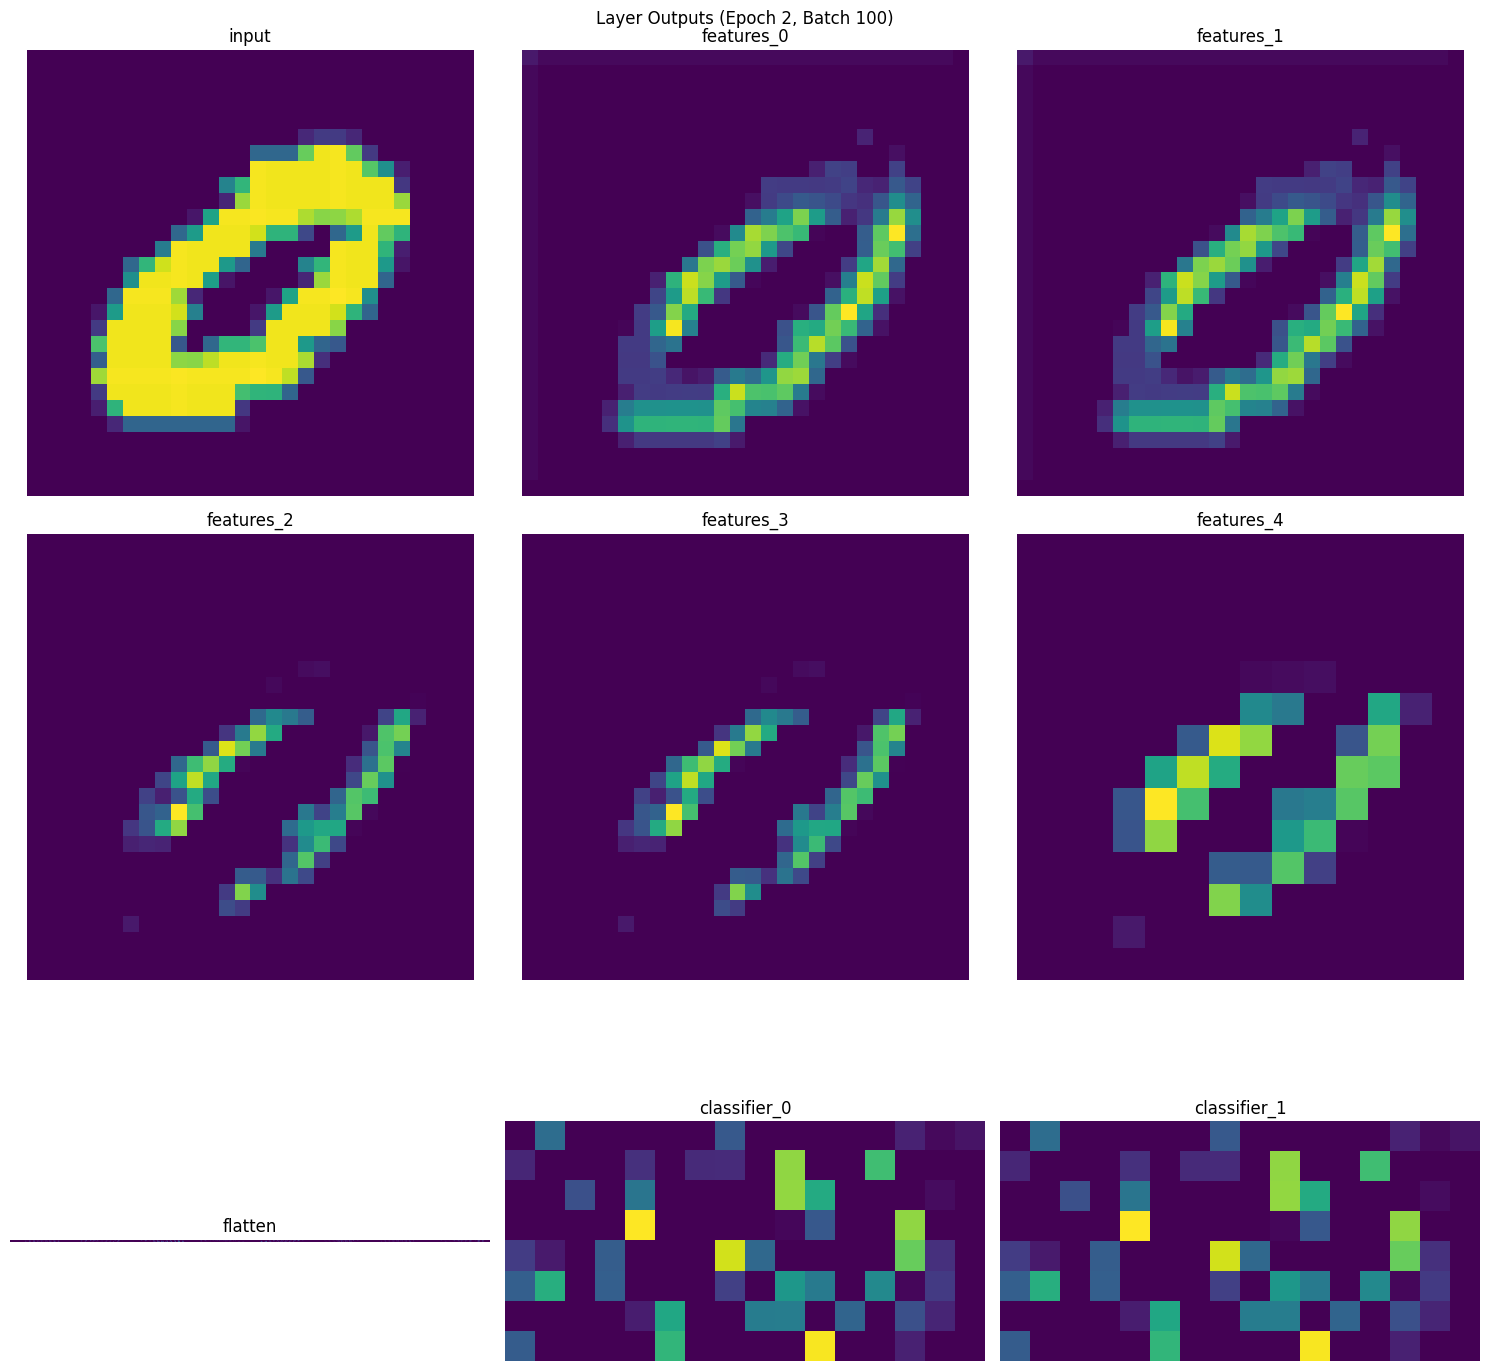


Analyzing pcoder layers:
Epoch 2/5, Batch 200/938, Loss: 0.0565


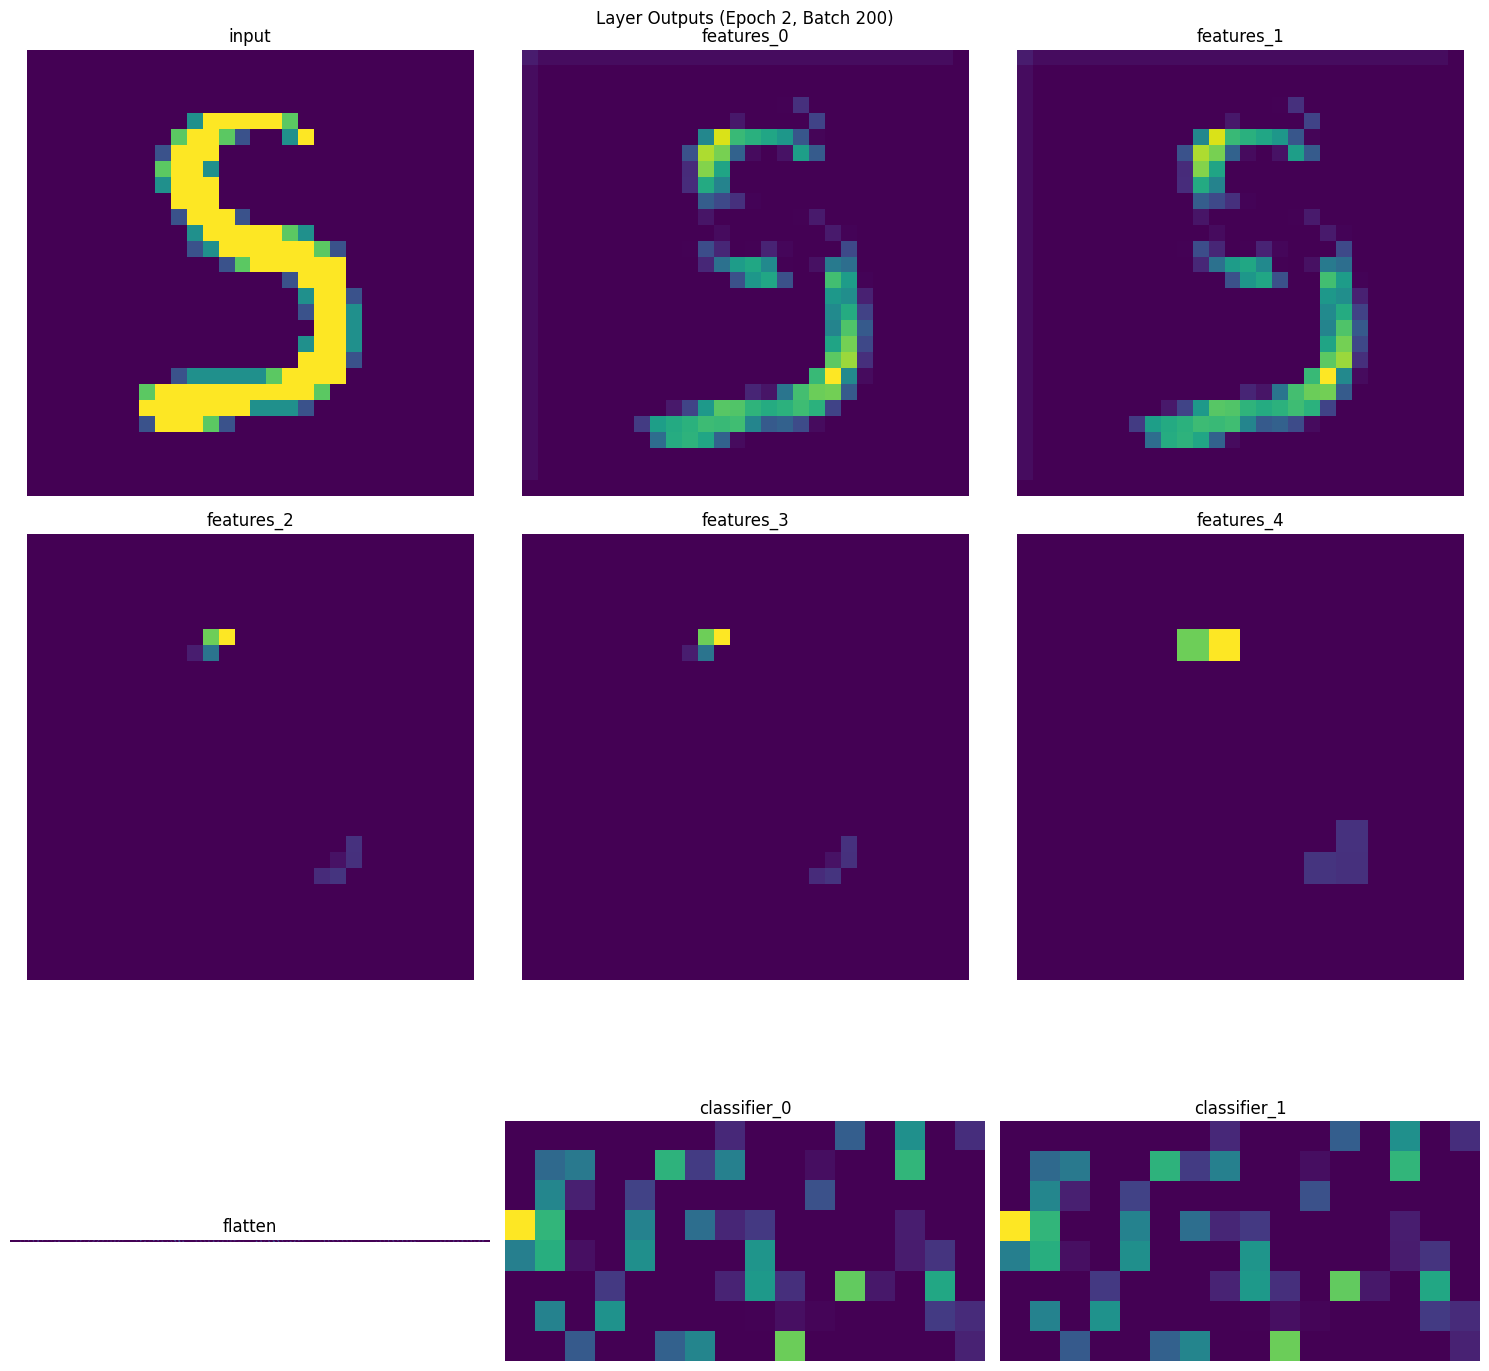


Analyzing pcoder layers:
Epoch 2/5, Batch 300/938, Loss: 0.0253


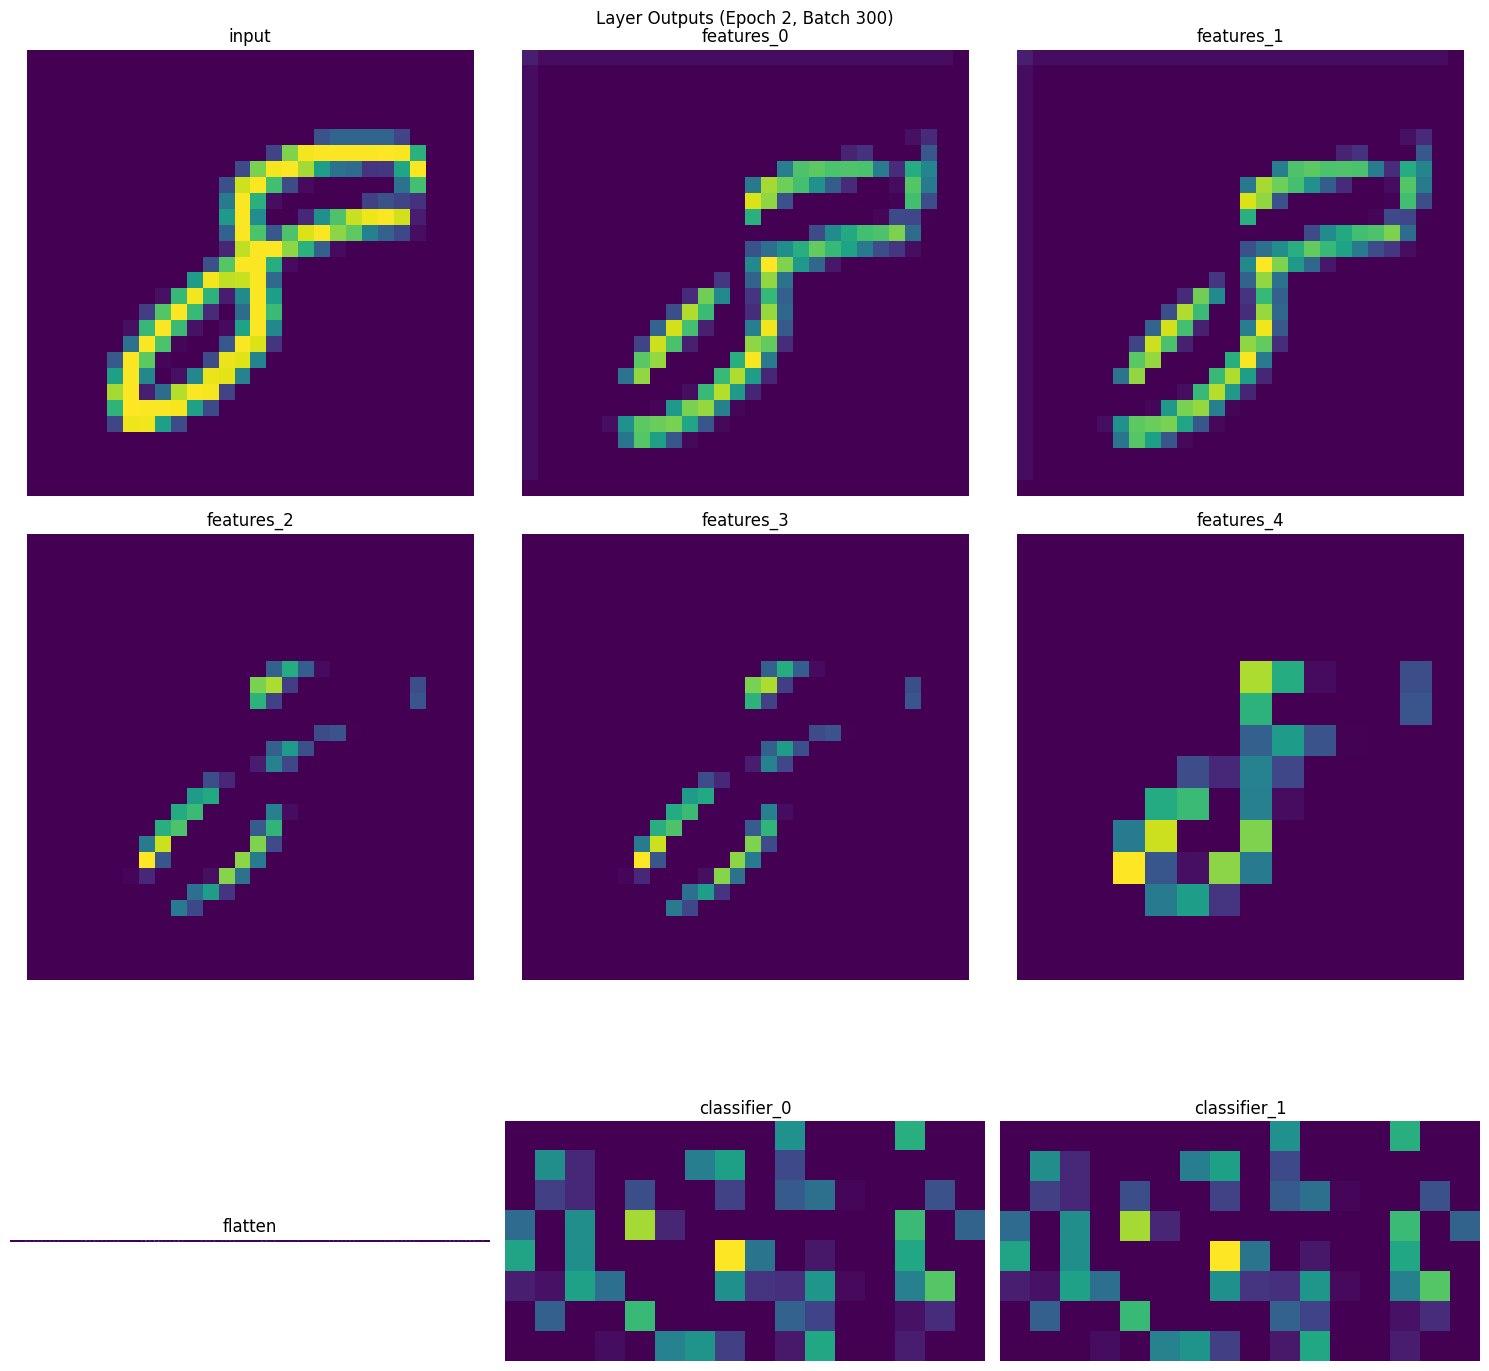


Analyzing pcoder layers:
Epoch 2/5, Batch 400/938, Loss: 0.0904


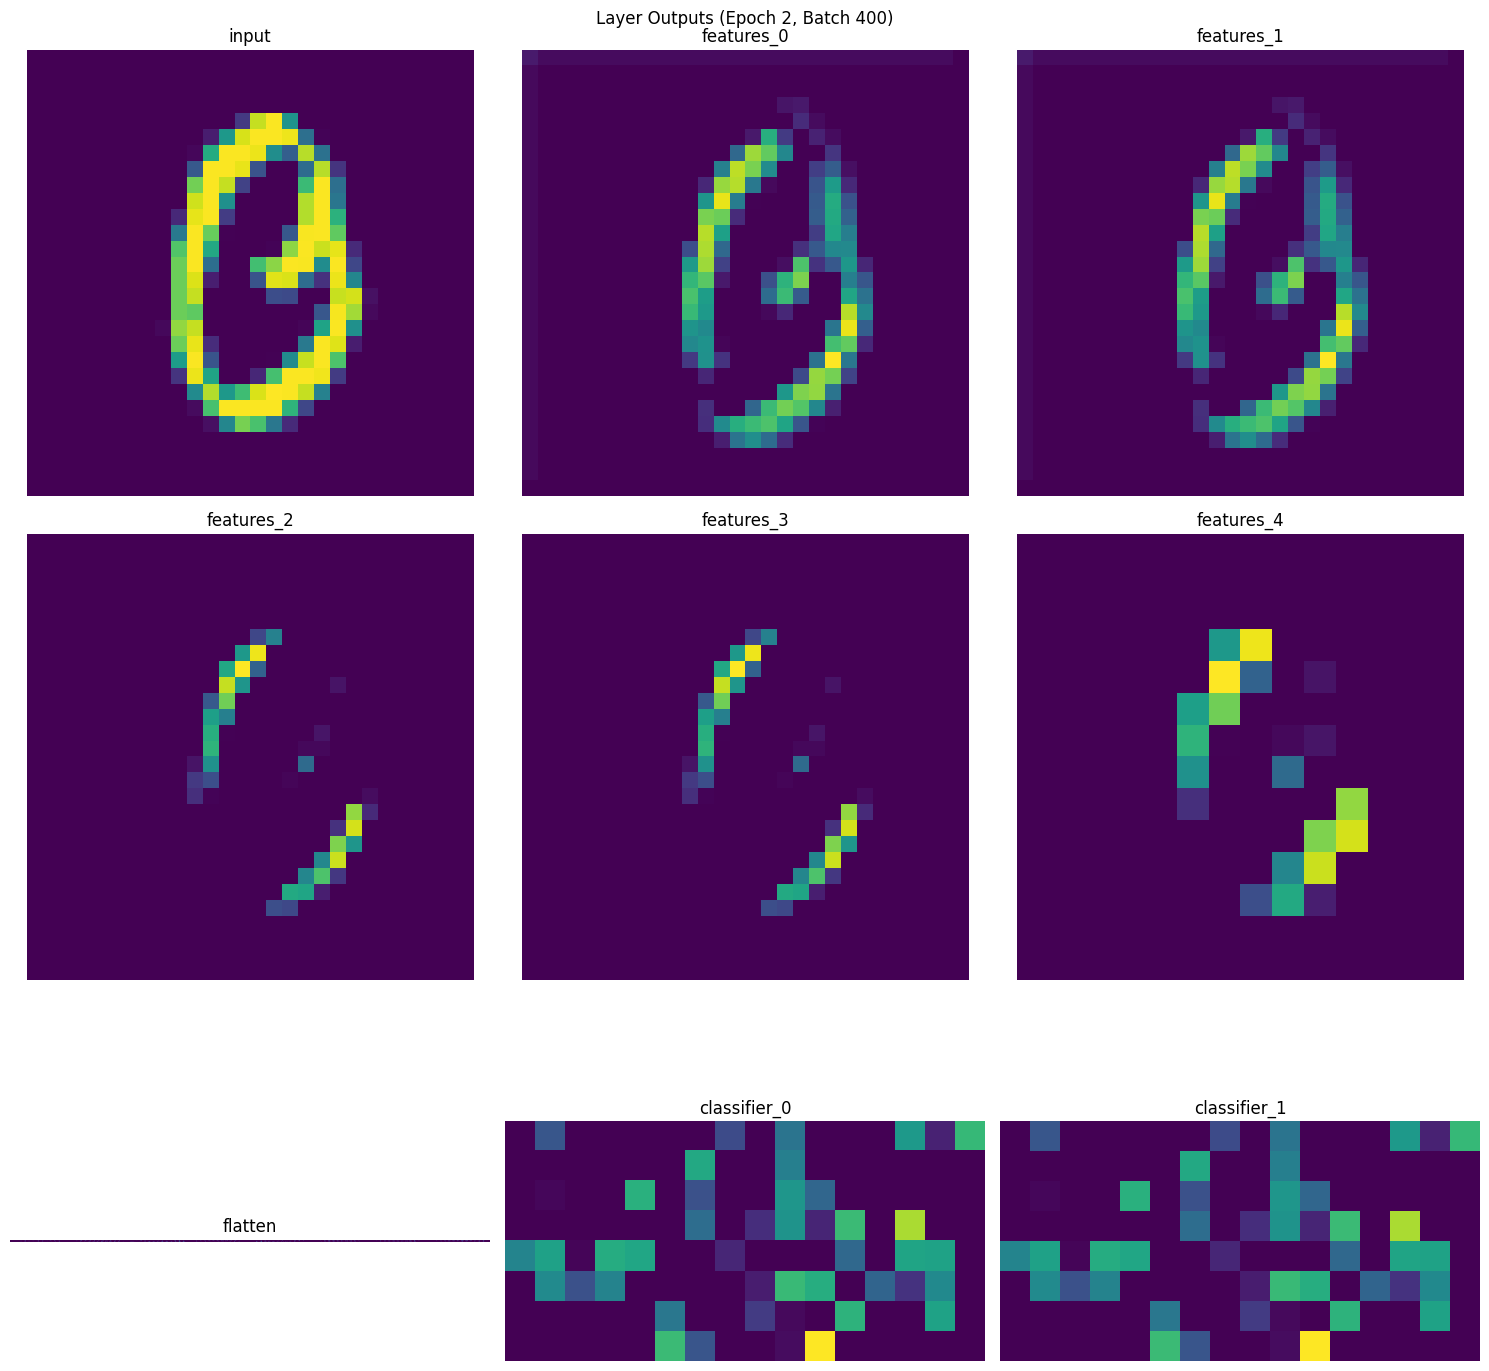


Analyzing pcoder layers:
Epoch 2/5, Batch 500/938, Loss: 0.2256


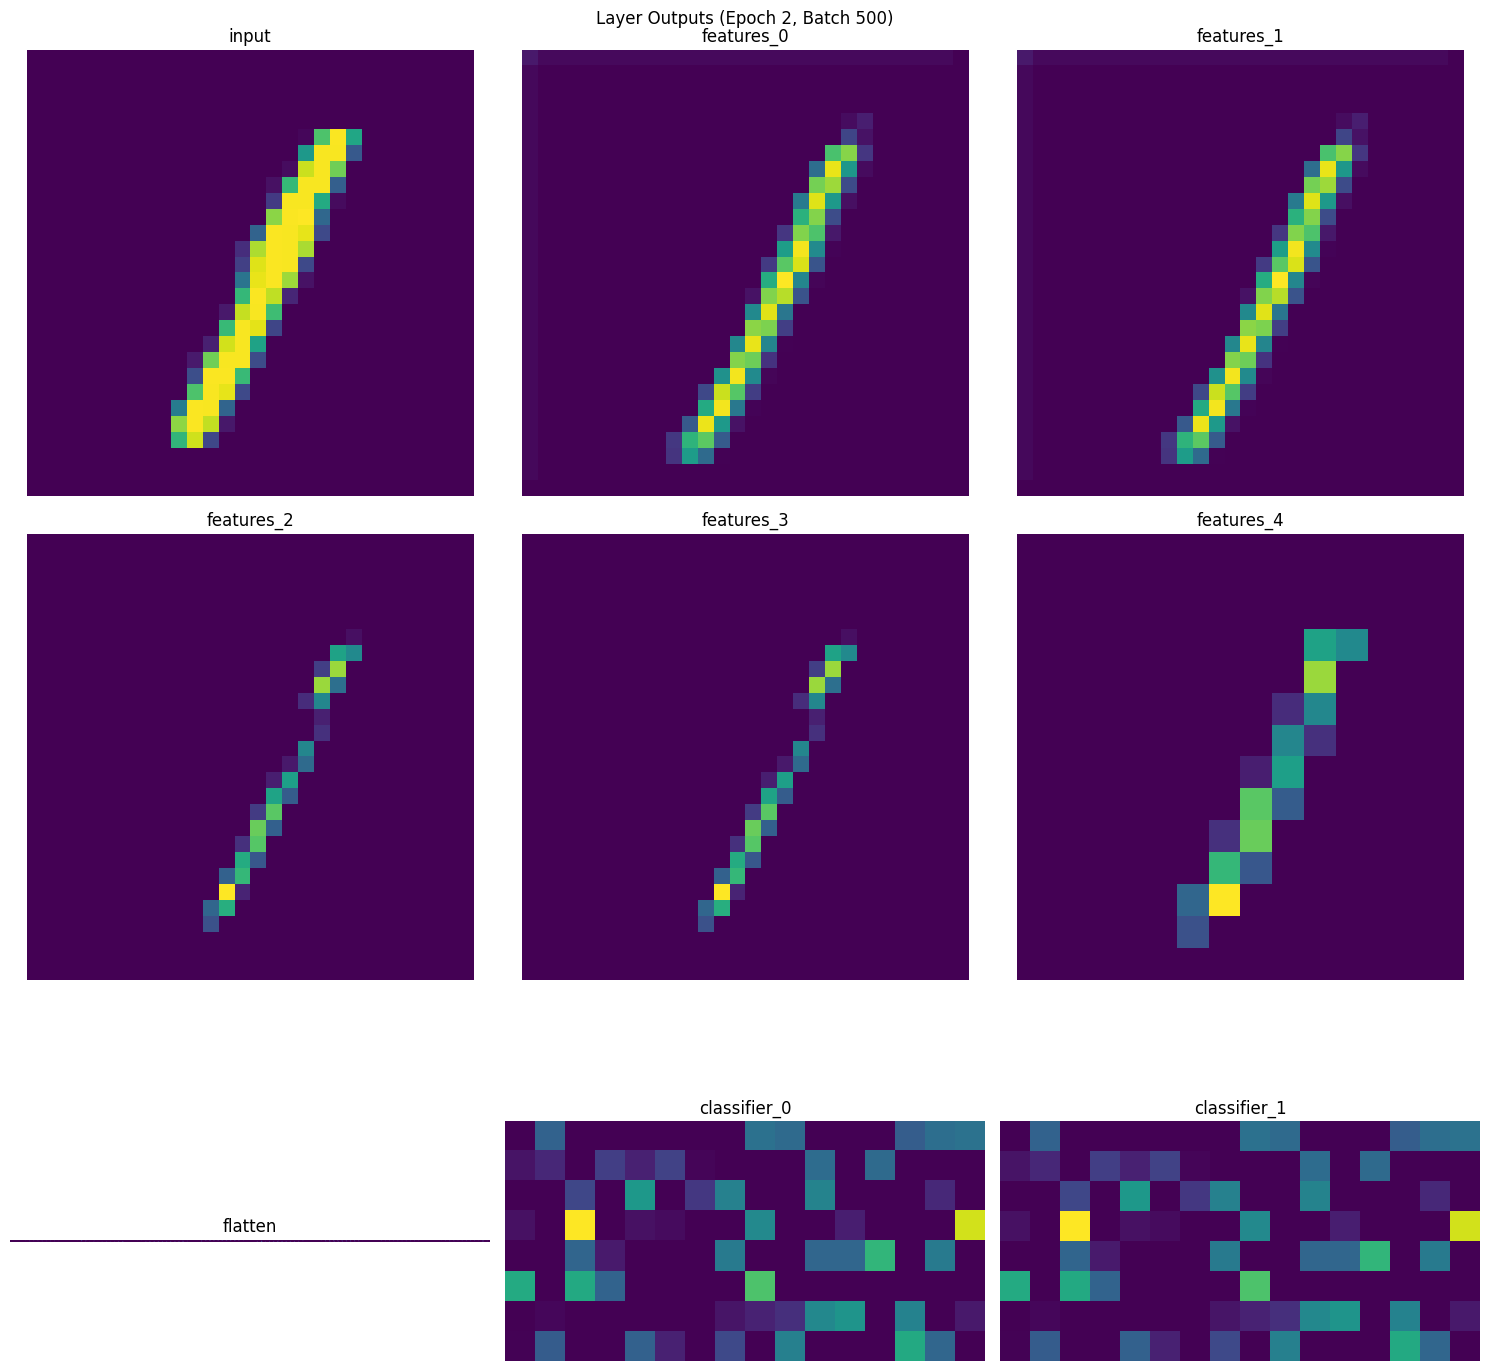


Analyzing pcoder layers:
Epoch 2/5, Batch 600/938, Loss: 0.0004


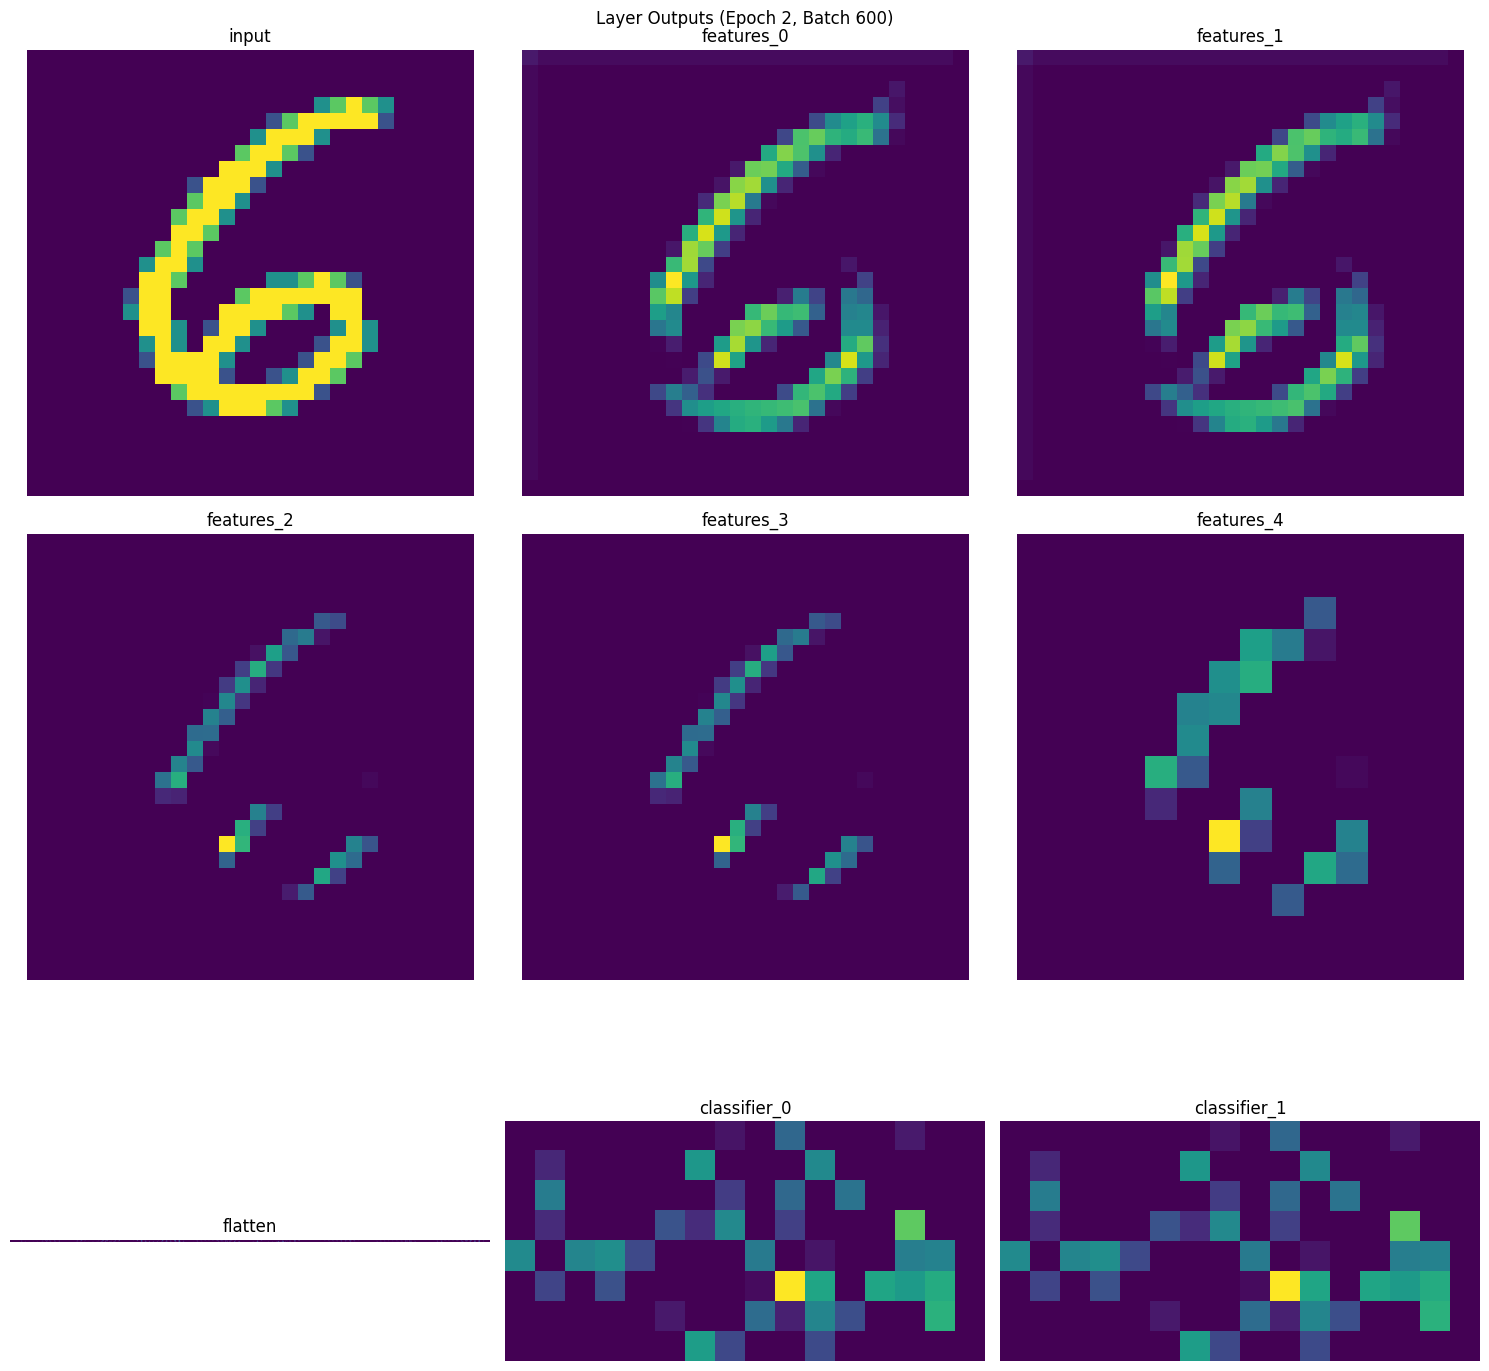


Analyzing pcoder layers:
Epoch 2/5, Batch 700/938, Loss: 0.0004


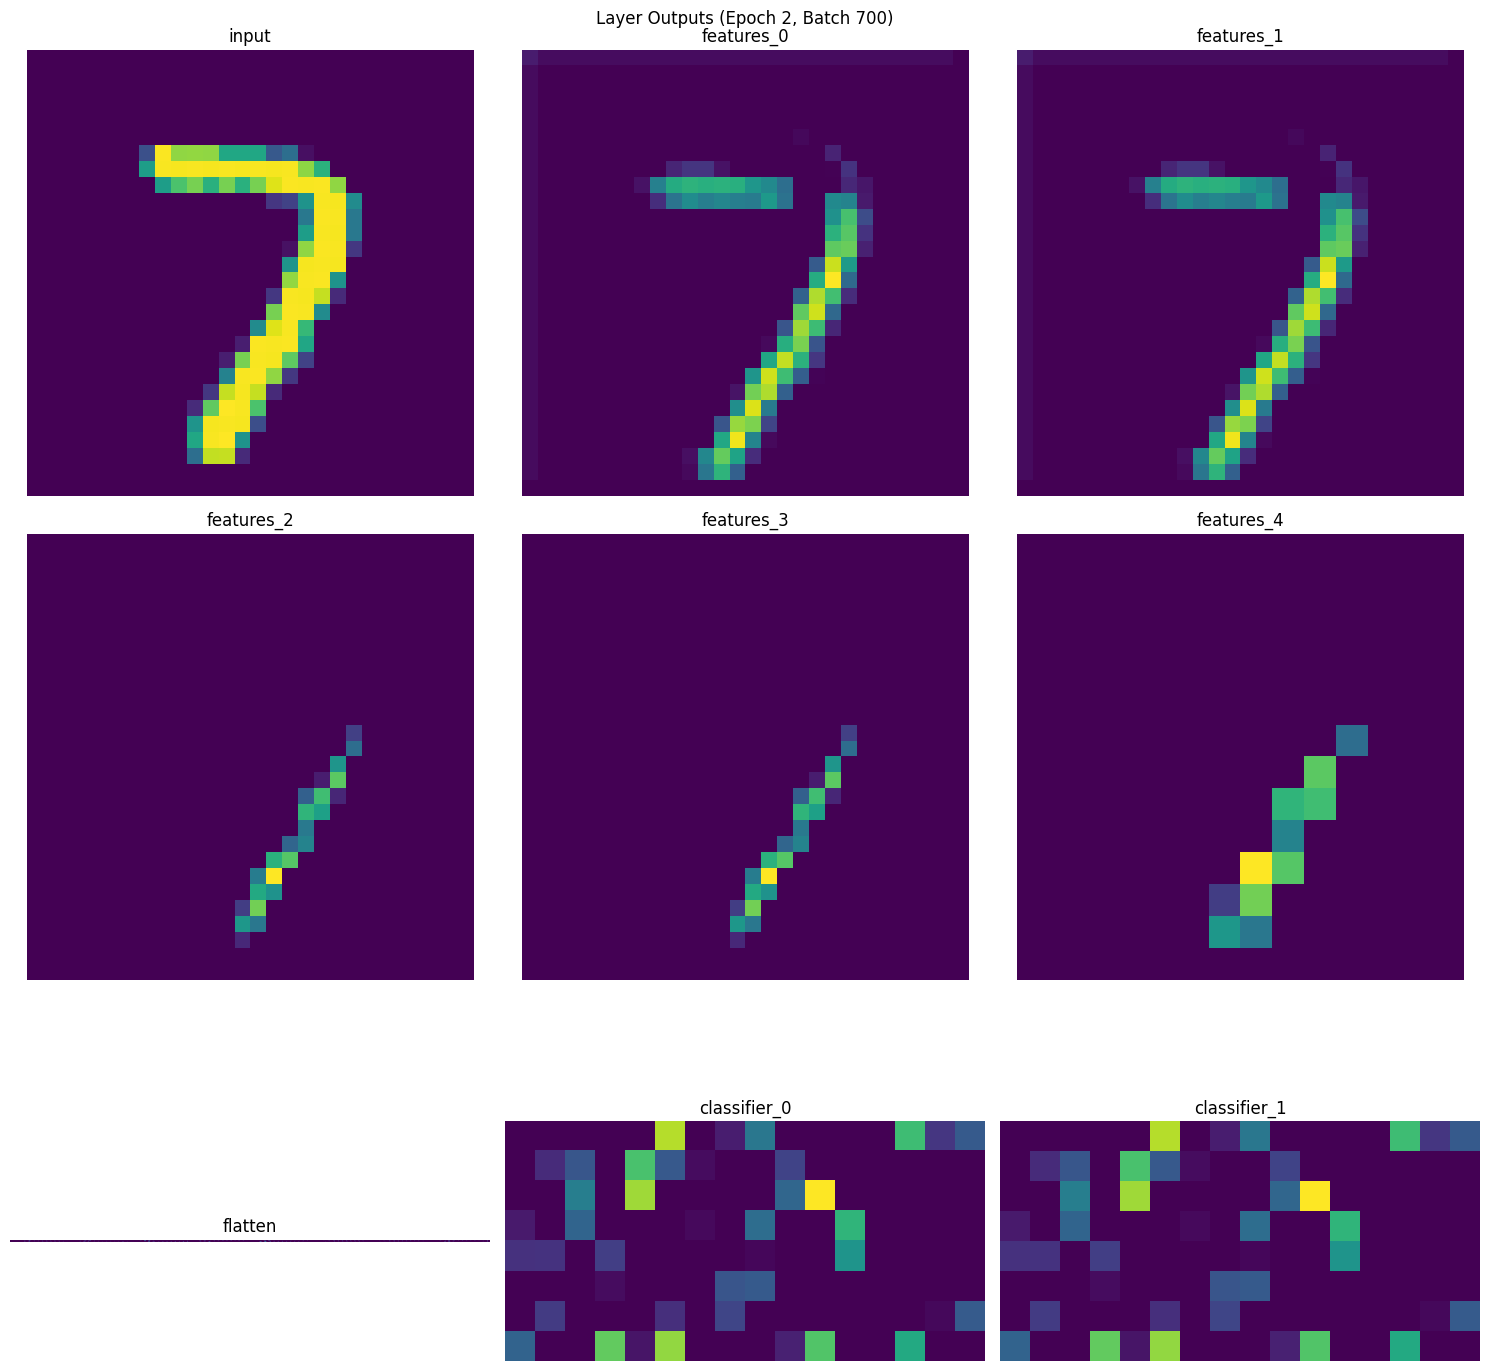


Analyzing pcoder layers:
Epoch 2/5, Batch 800/938, Loss: 0.0212


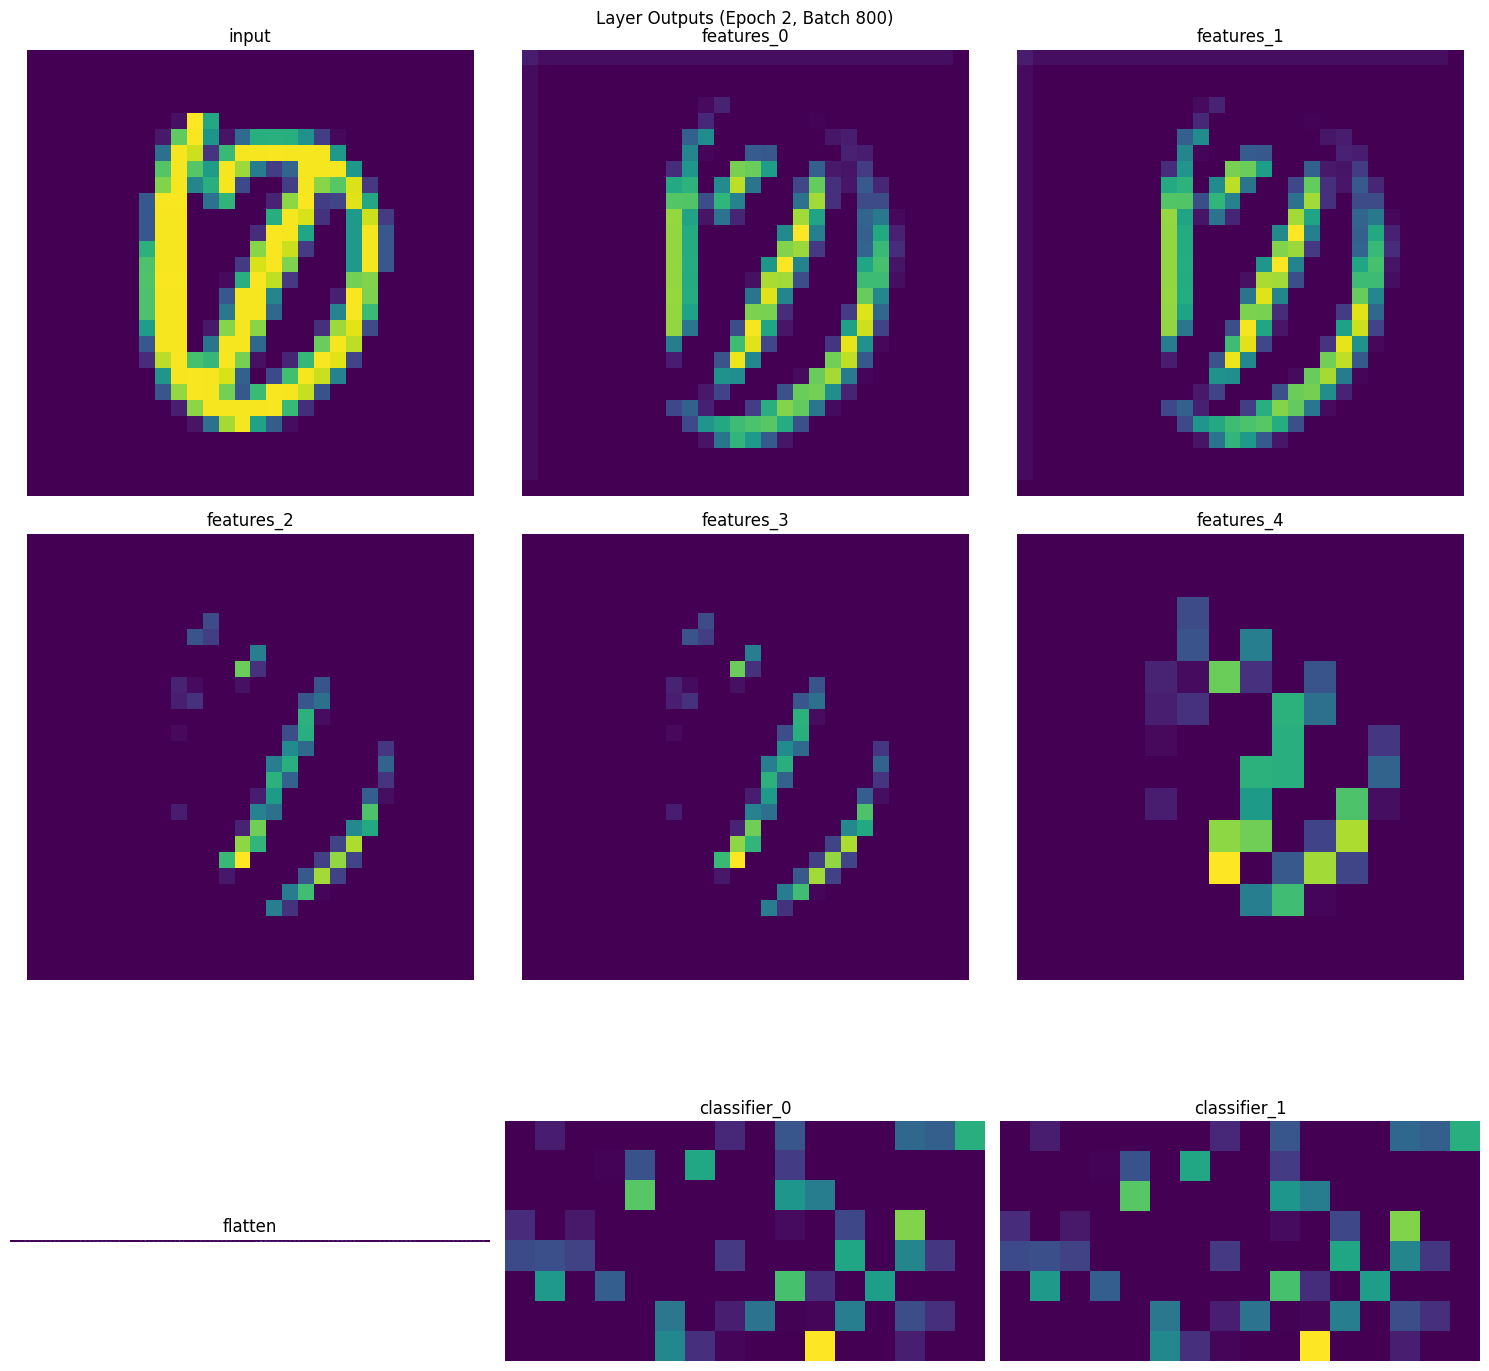


Analyzing pcoder layers:
Epoch 2/5, Batch 900/938, Loss: 0.0097


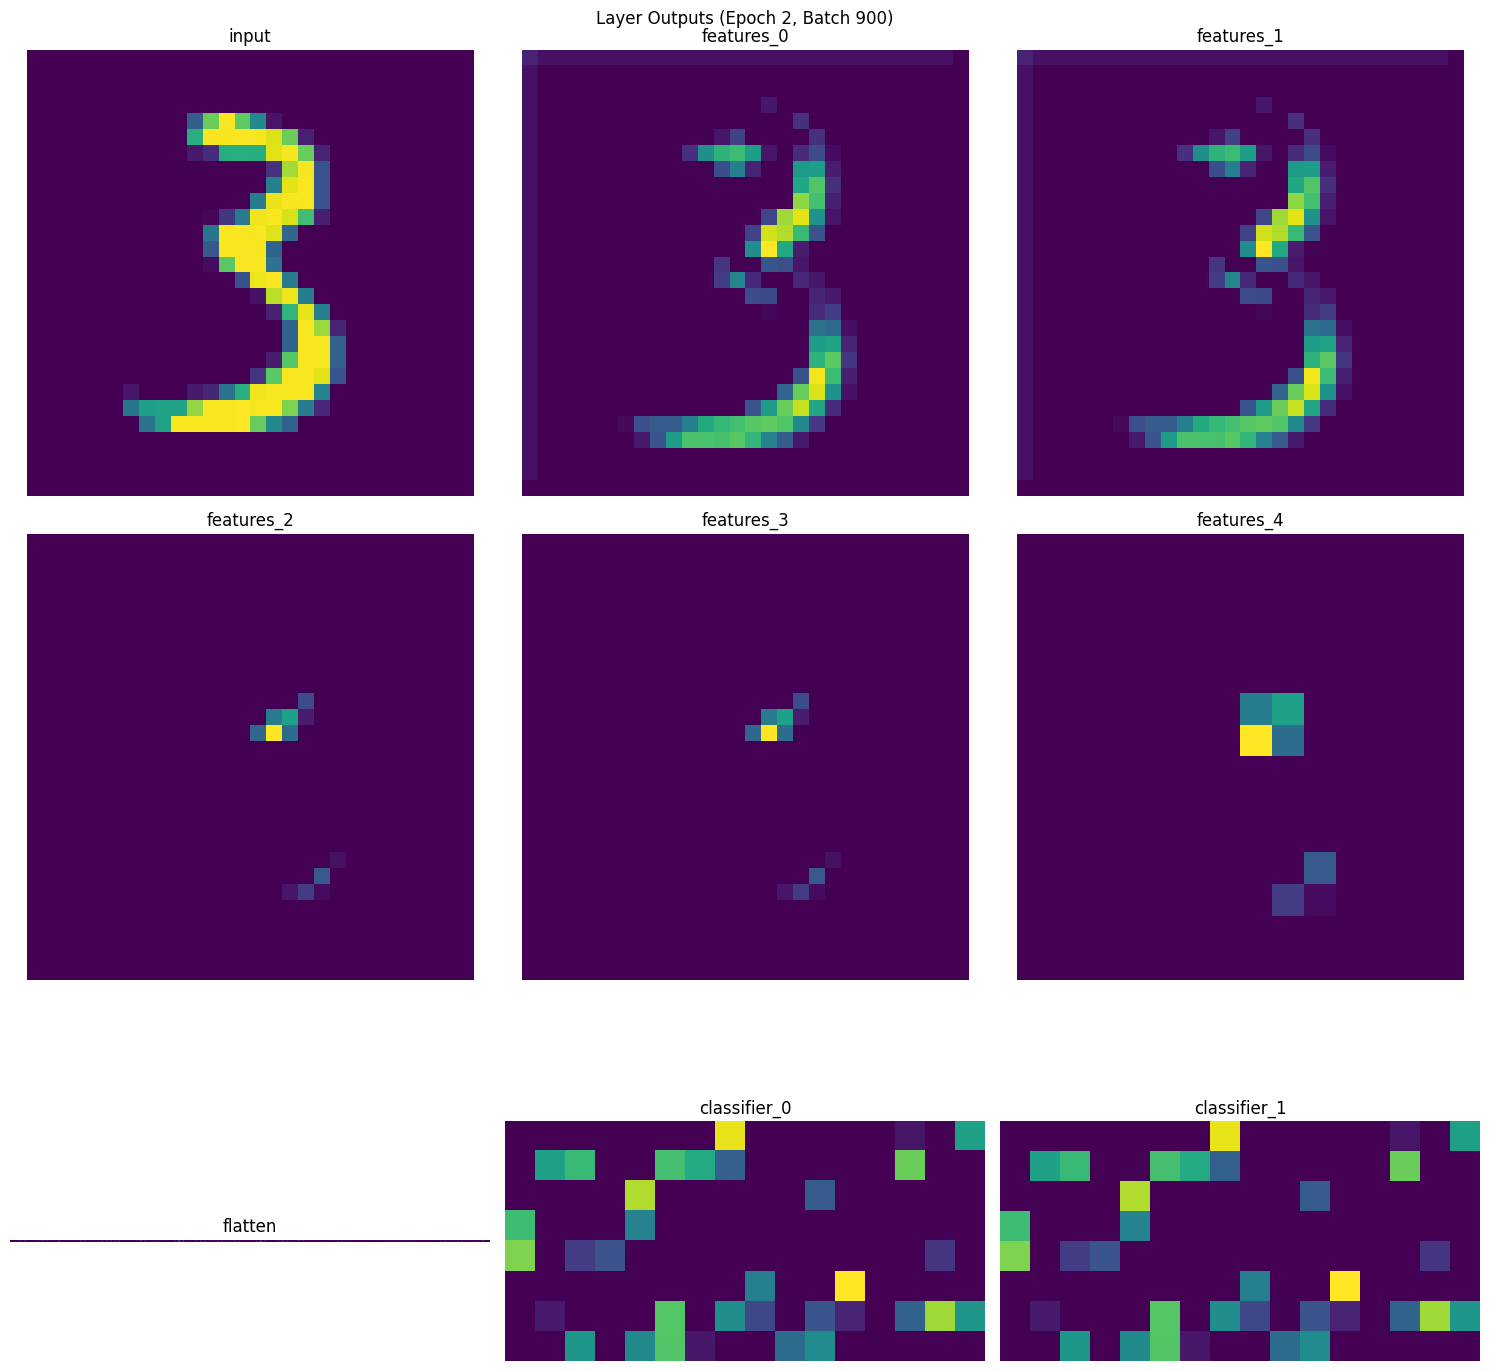


Analyzing pcoder layers:
Epoch 3/5, Batch 0/938, Loss: 0.0008


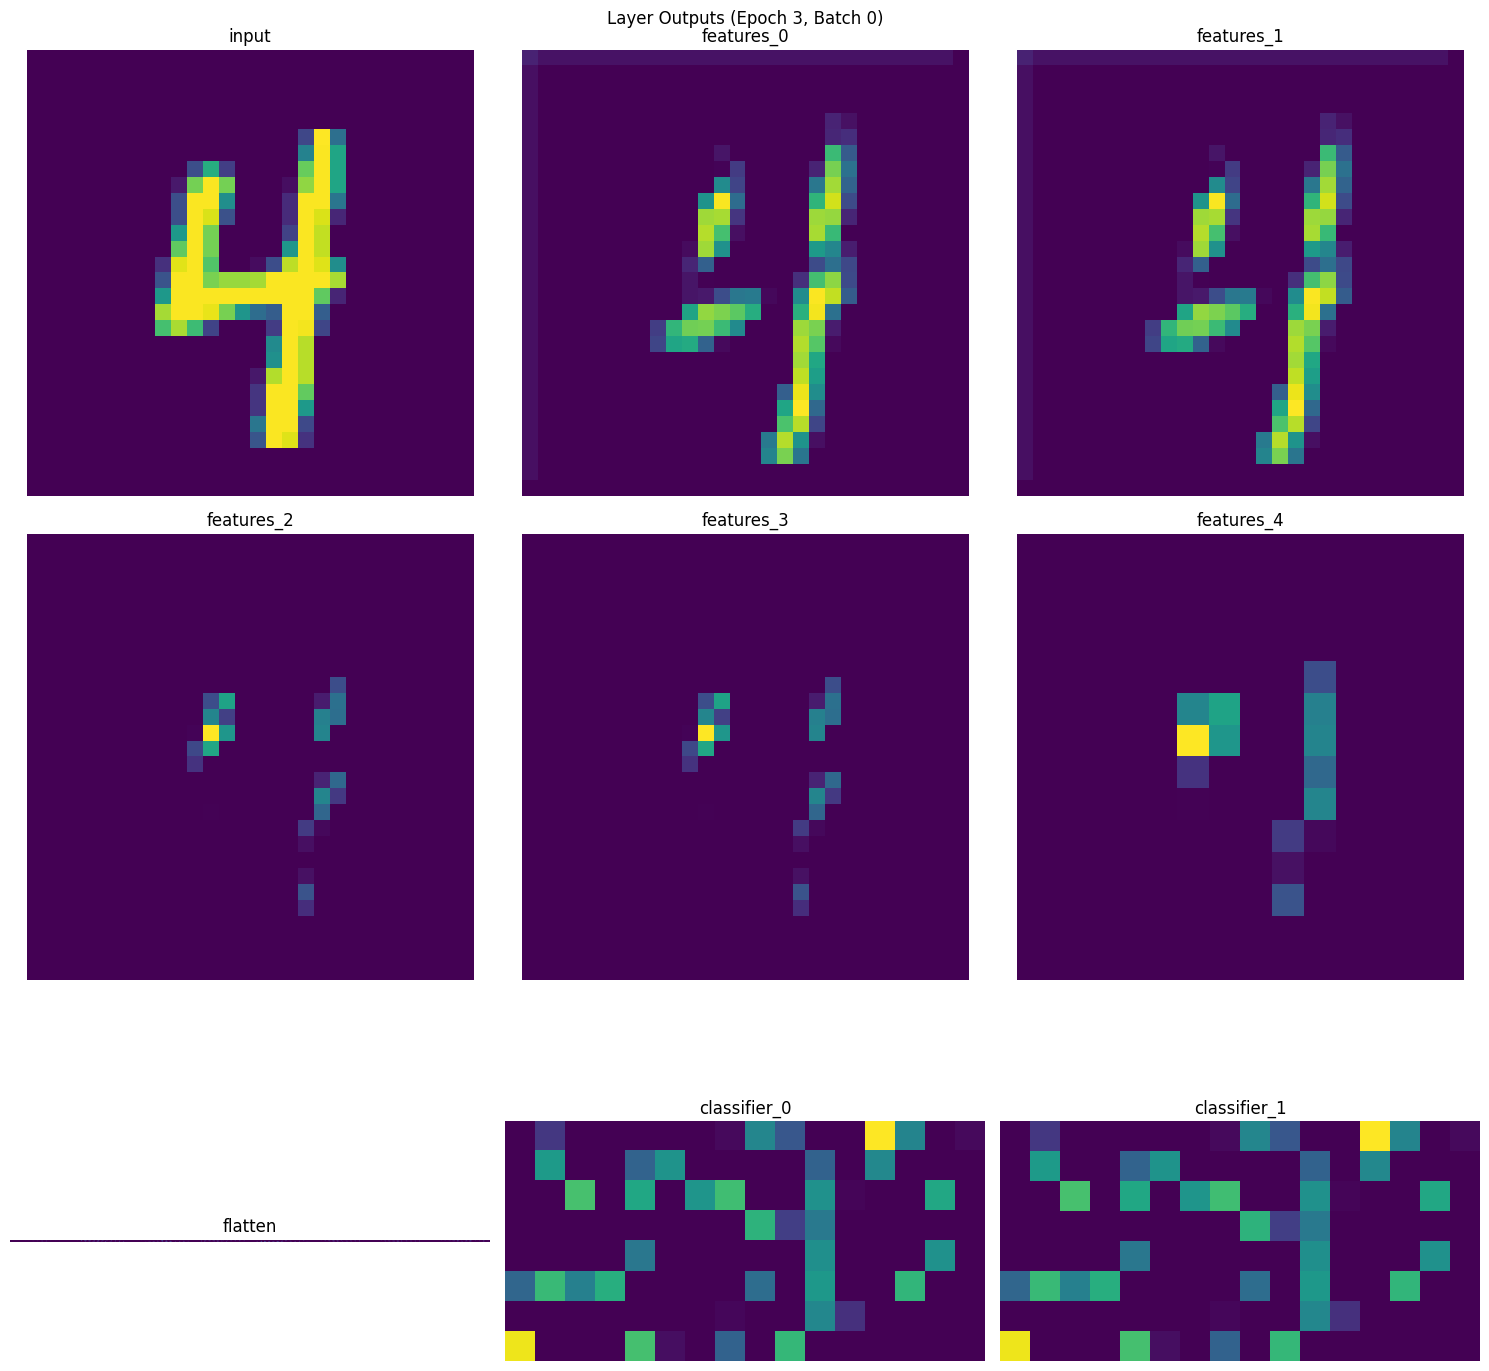


Analyzing pcoder layers:
Epoch 3/5, Batch 100/938, Loss: 0.0247


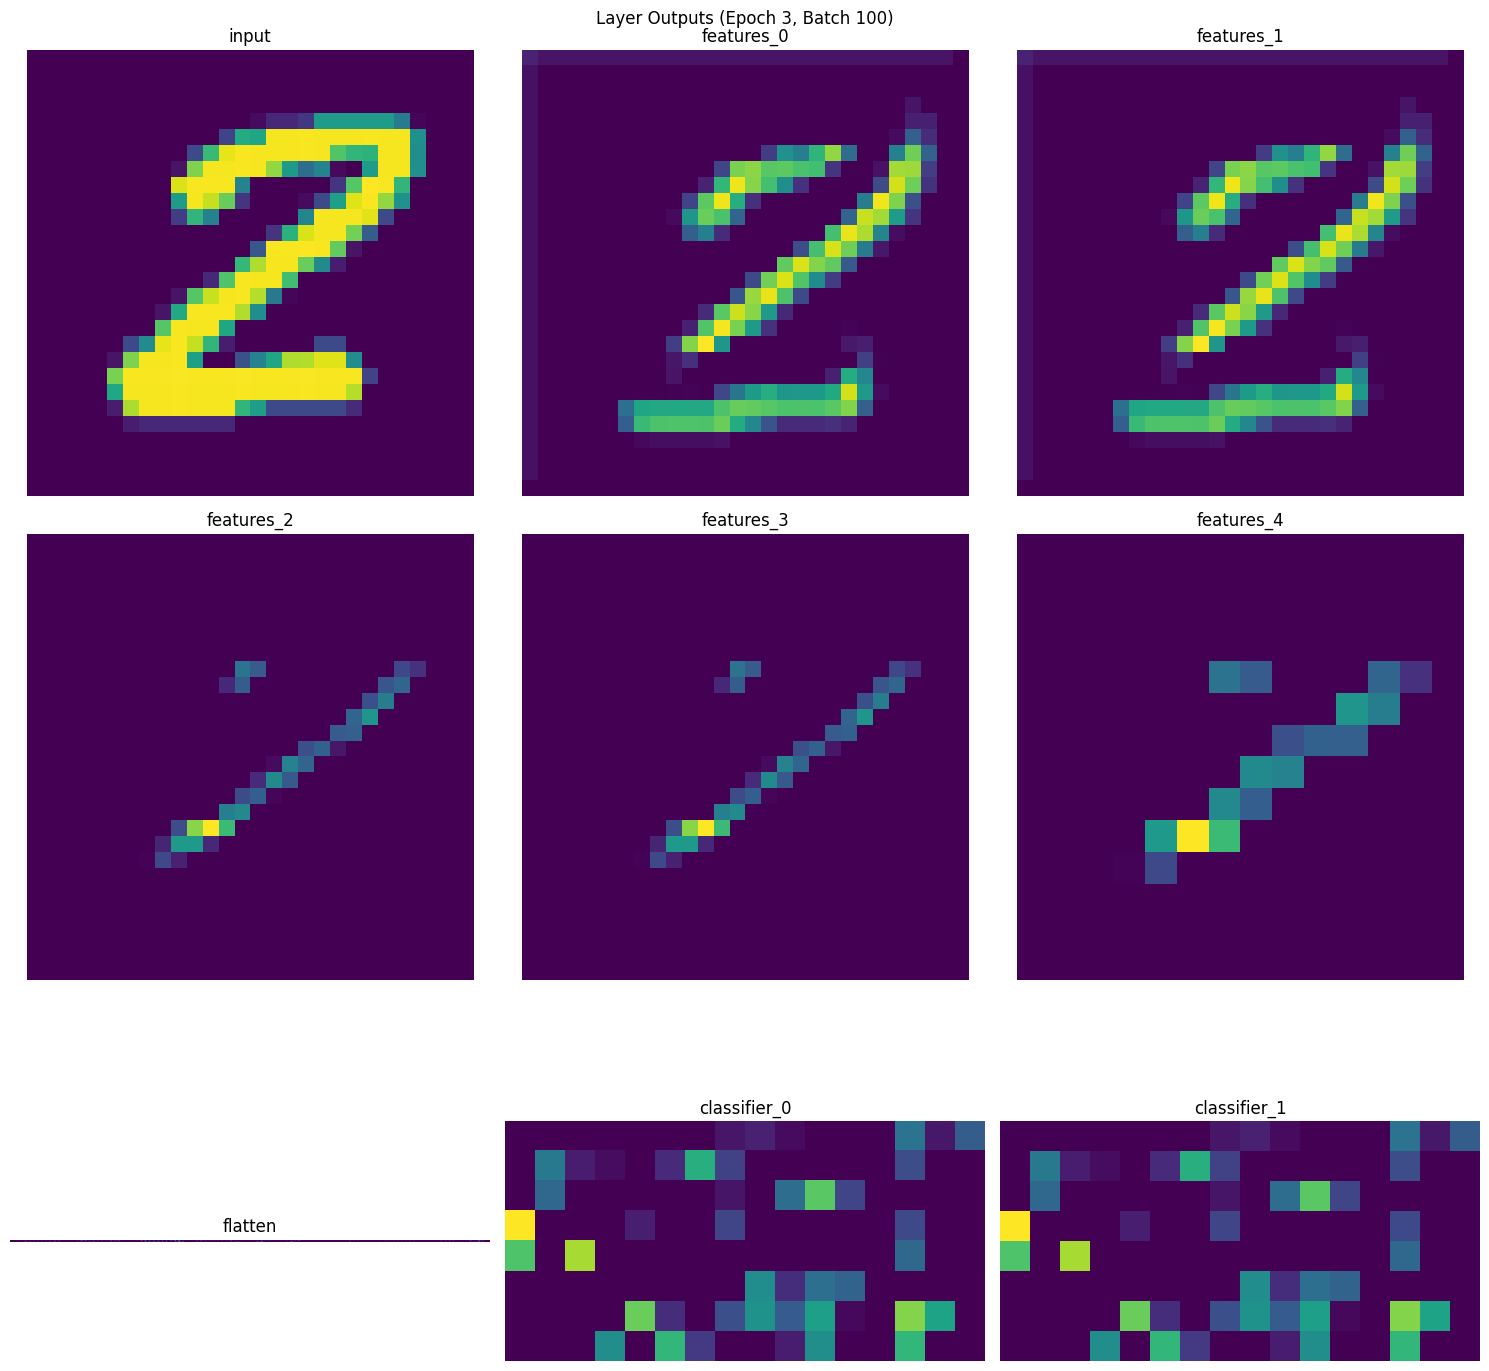


Analyzing pcoder layers:
Epoch 3/5, Batch 200/938, Loss: 0.0146


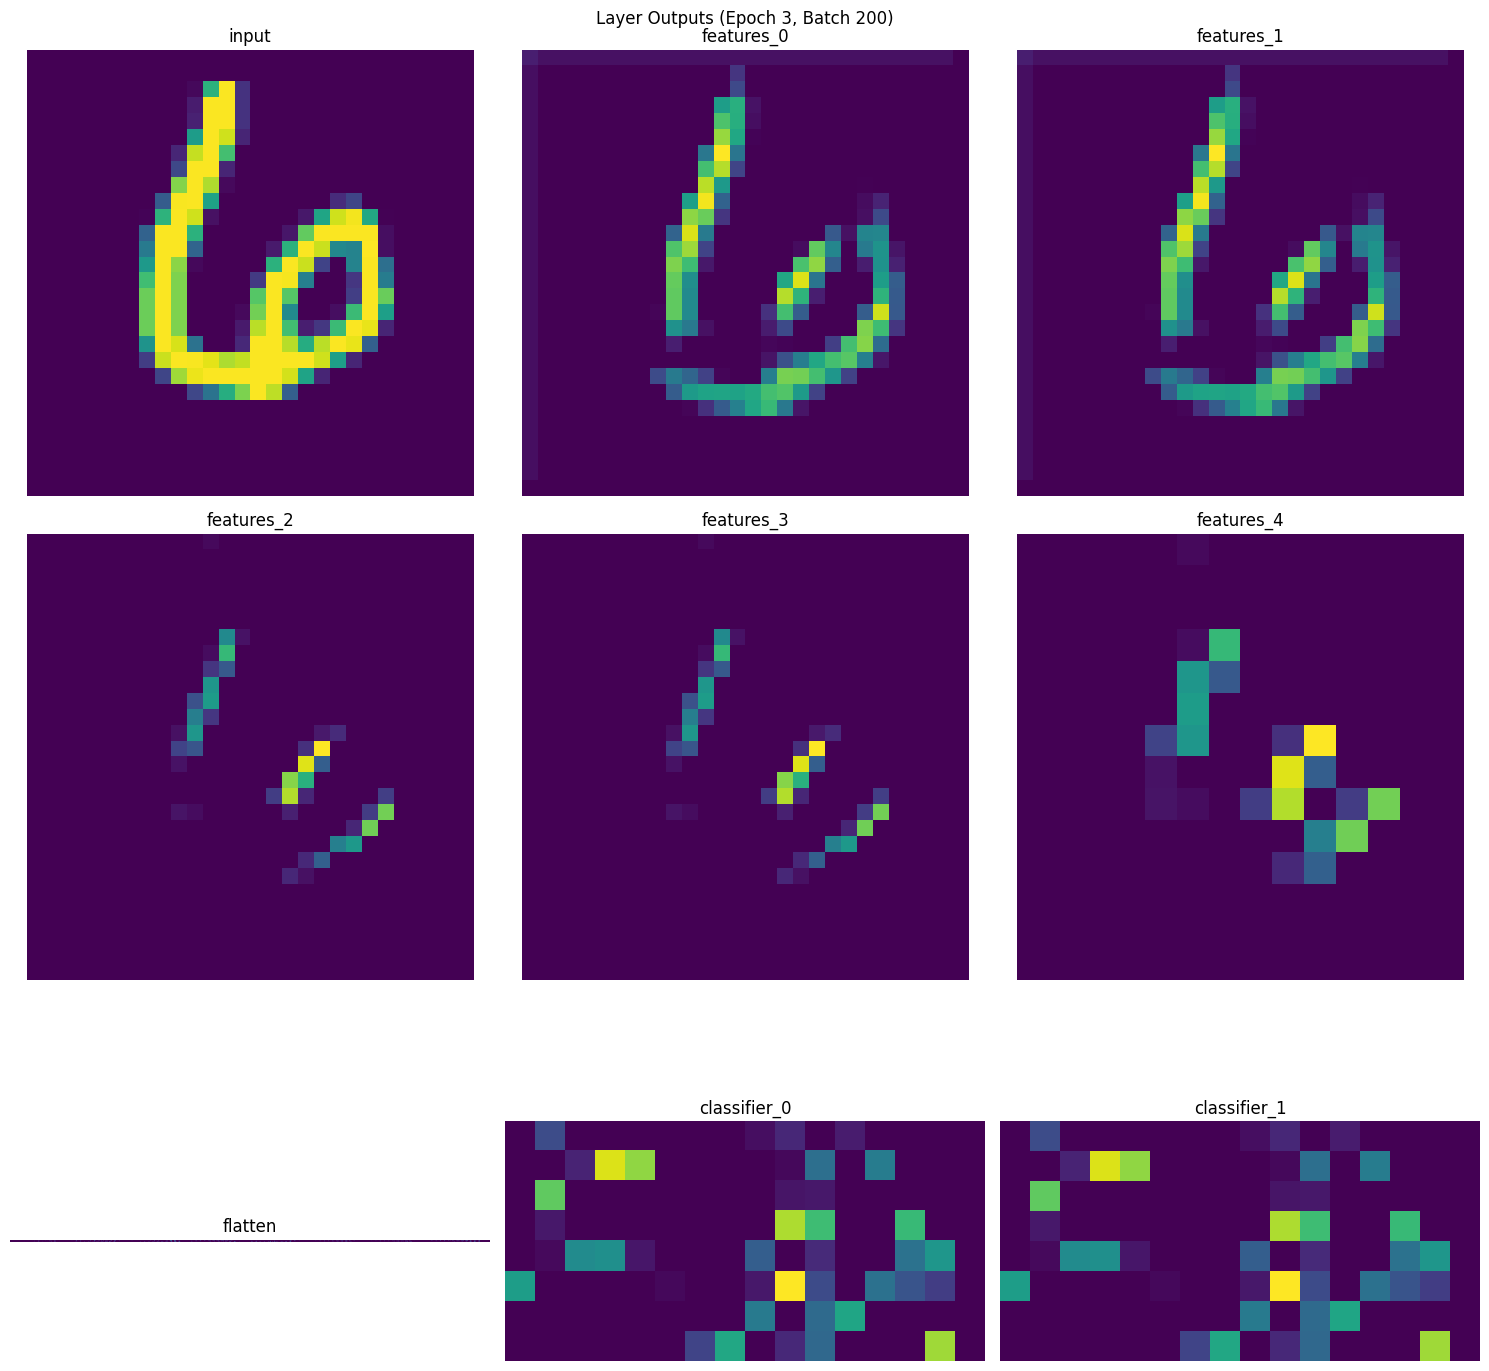


Analyzing pcoder layers:
Epoch 3/5, Batch 300/938, Loss: 0.0025


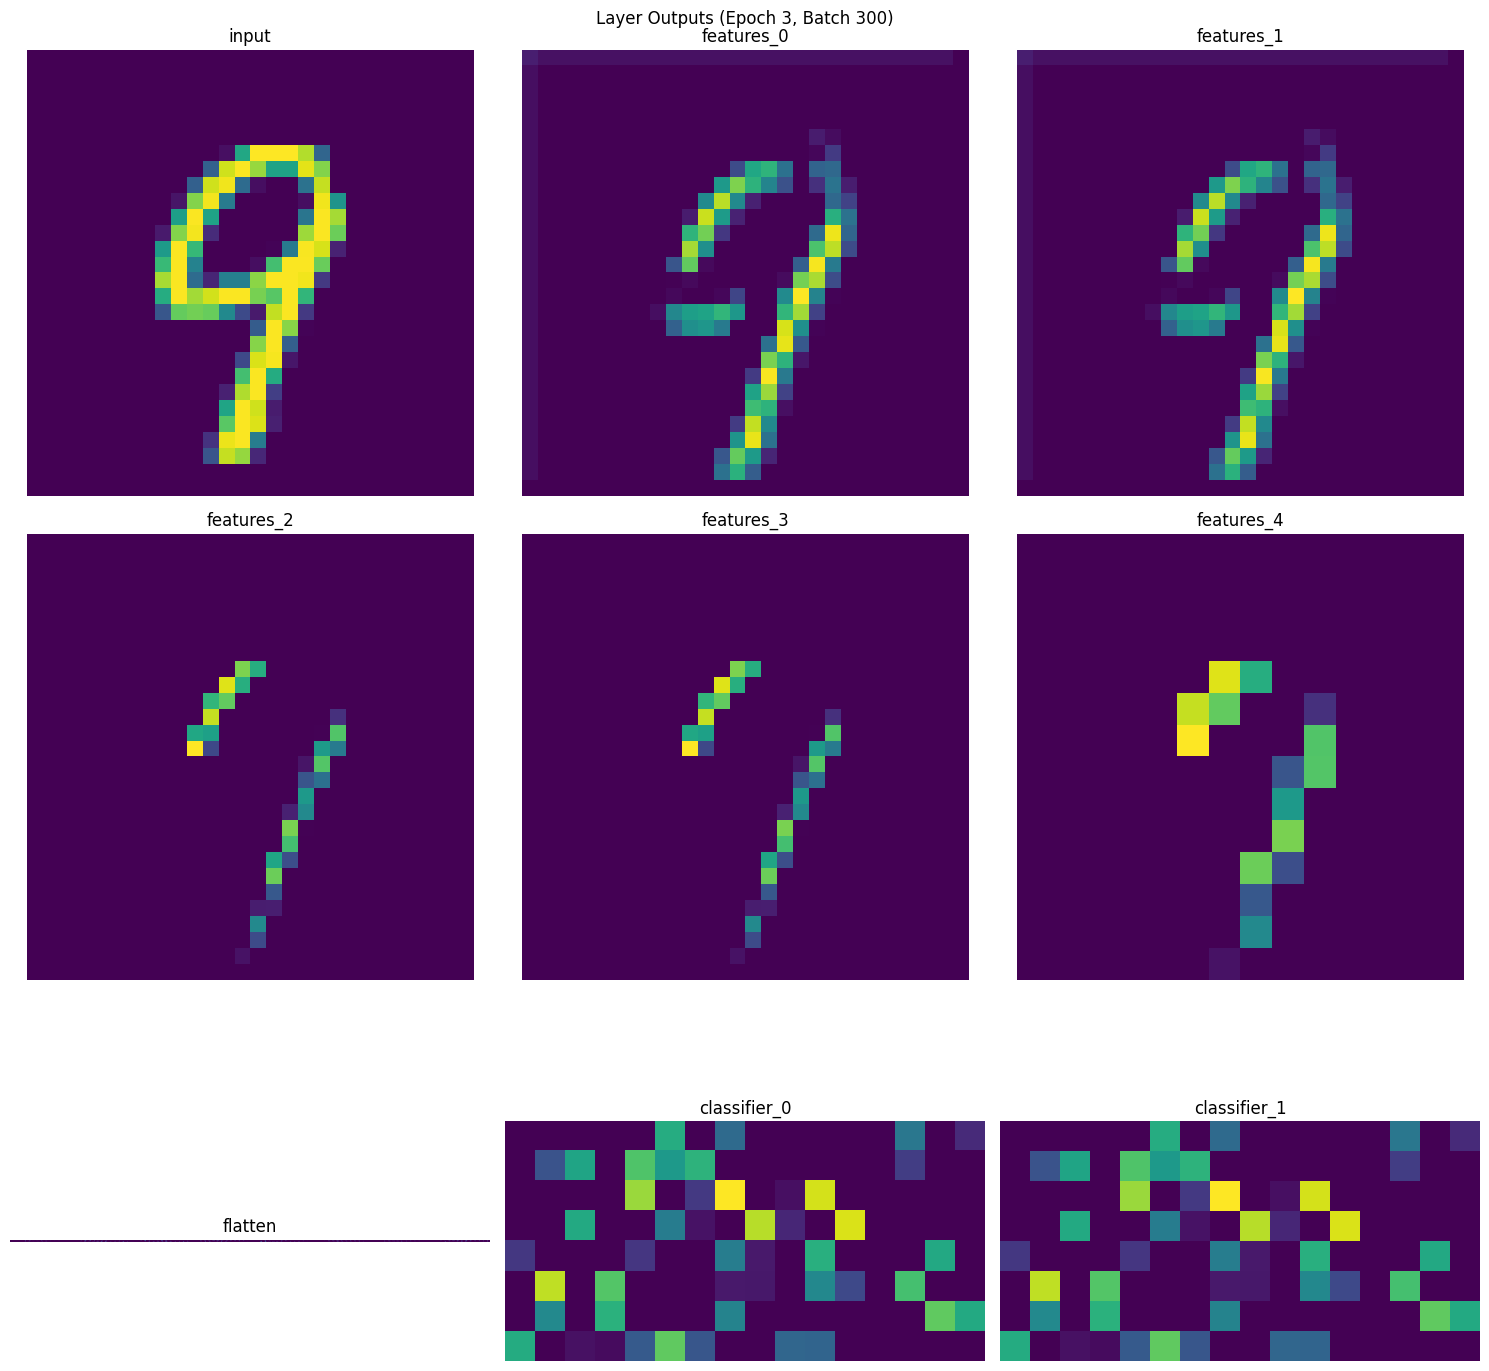


Analyzing pcoder layers:
Epoch 3/5, Batch 400/938, Loss: 0.0725


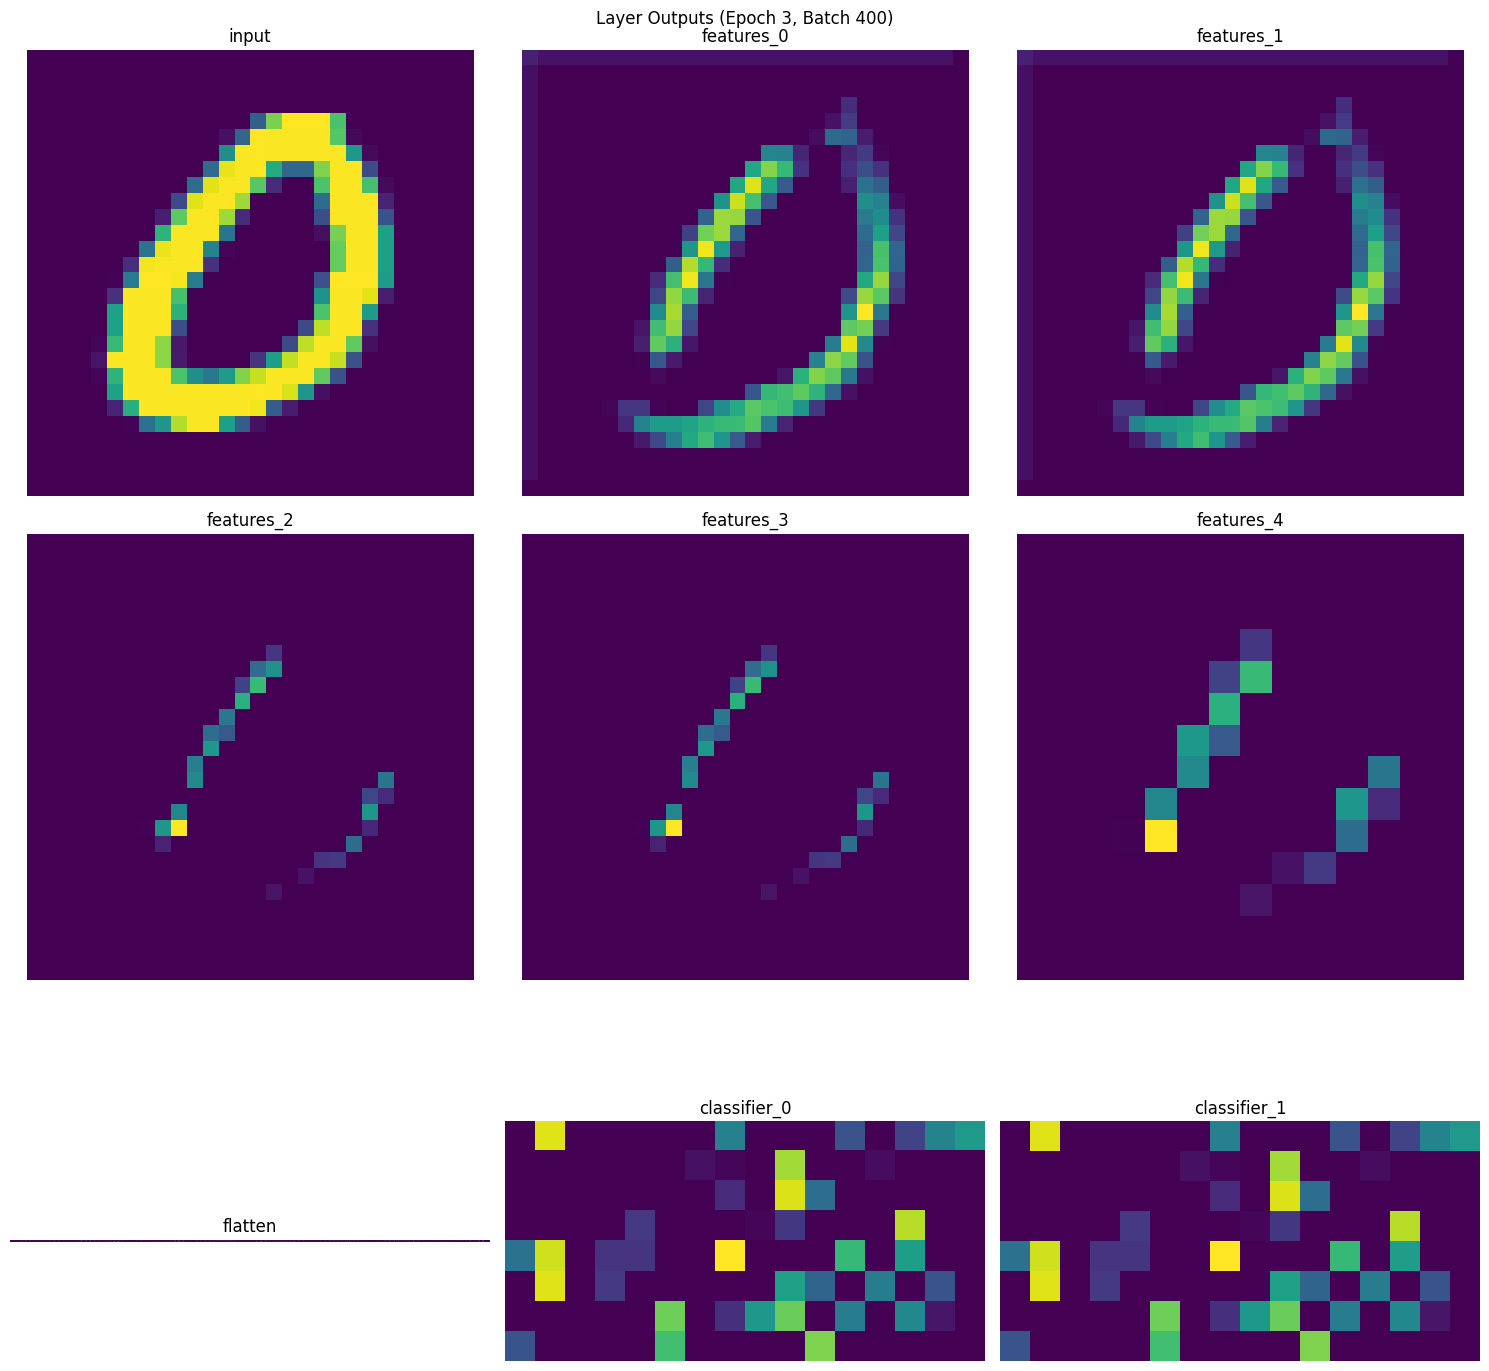


Analyzing pcoder layers:
Epoch 3/5, Batch 500/938, Loss: 0.0549


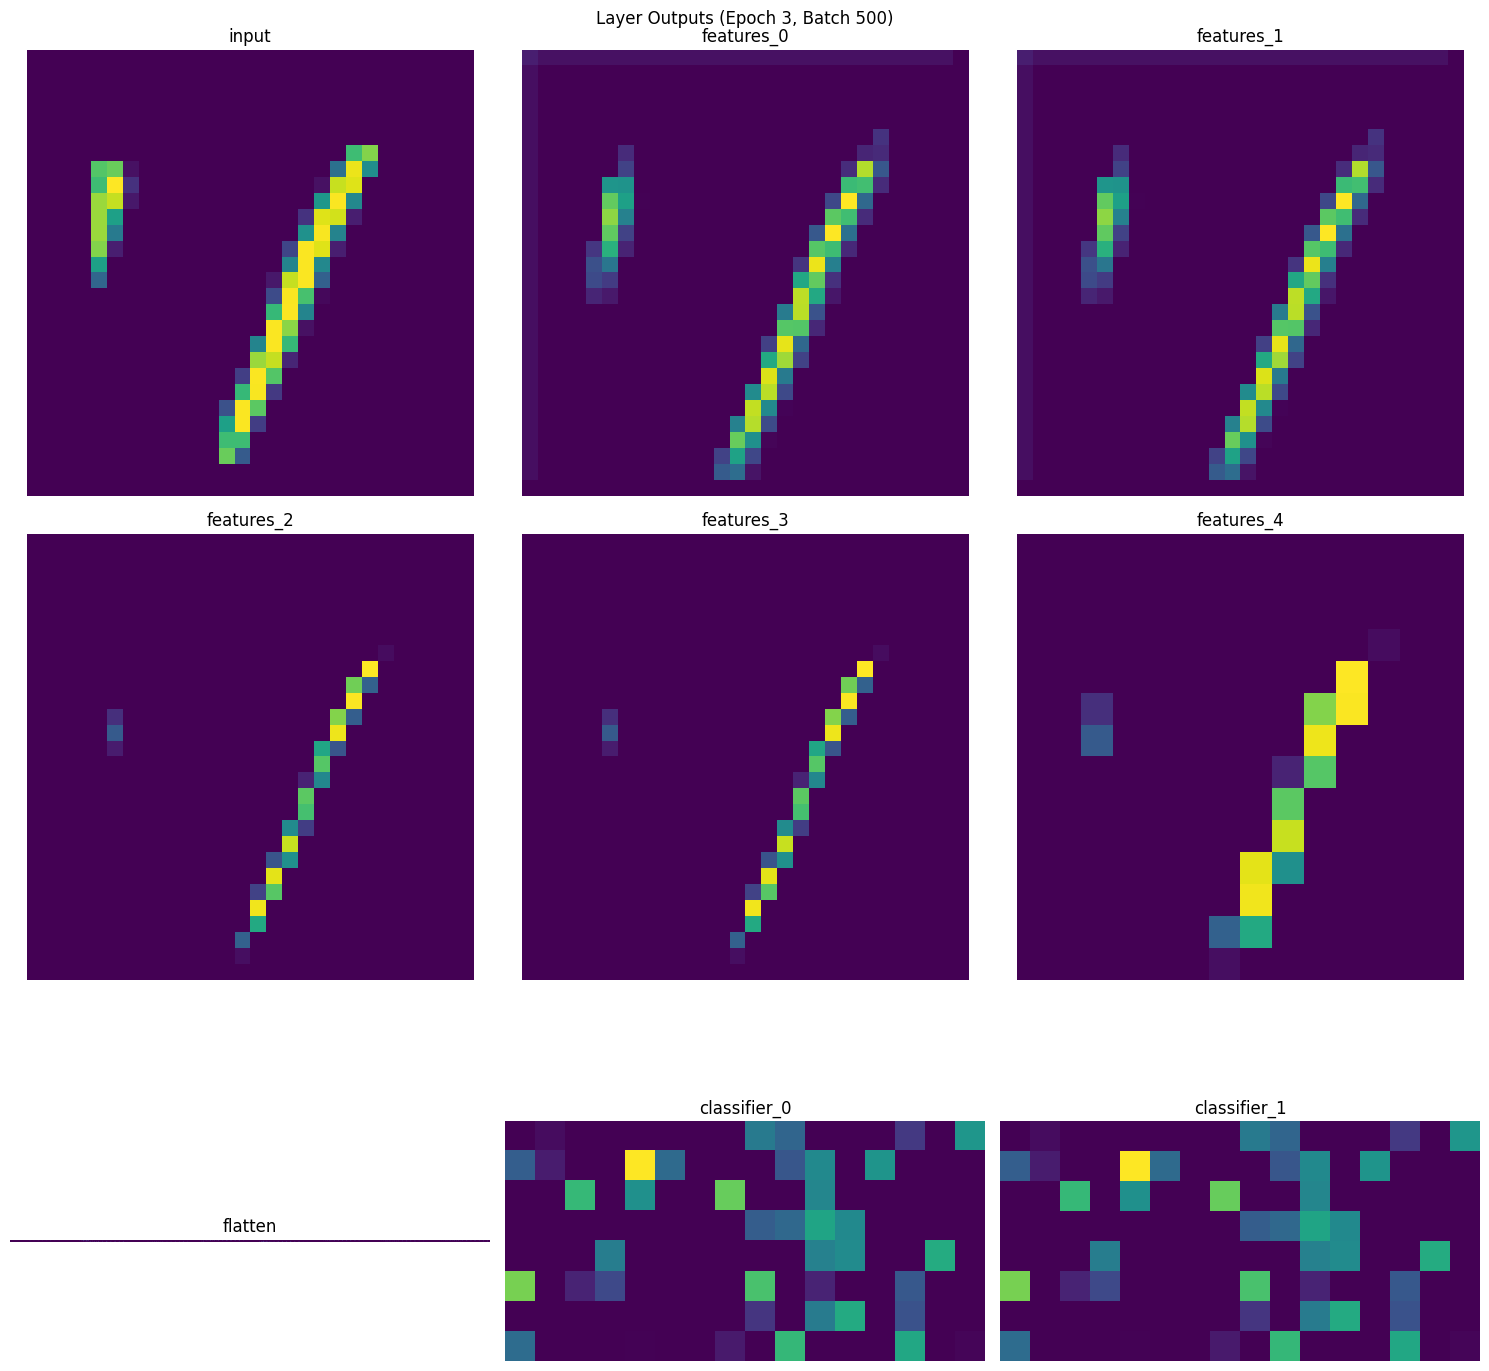


Analyzing pcoder layers:
Epoch 3/5, Batch 600/938, Loss: 0.0236


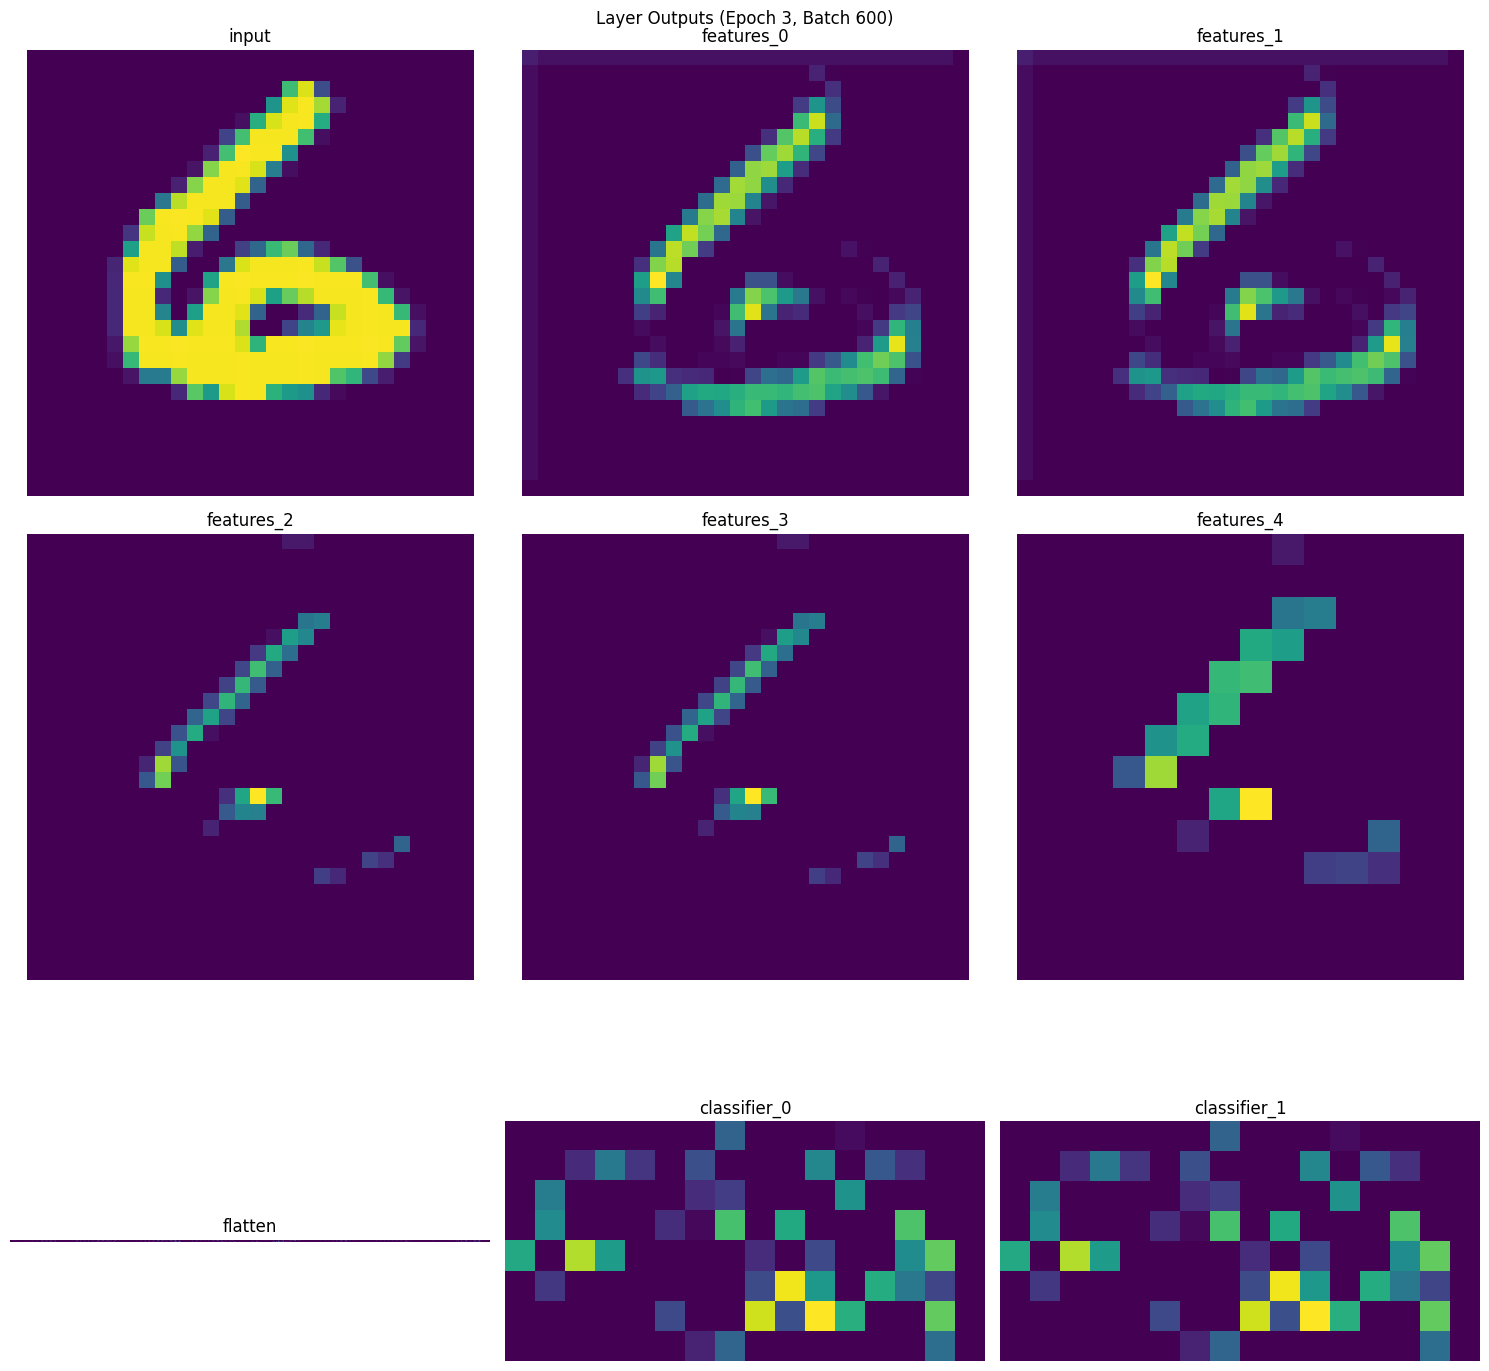


Analyzing pcoder layers:
Epoch 3/5, Batch 700/938, Loss: 0.0375


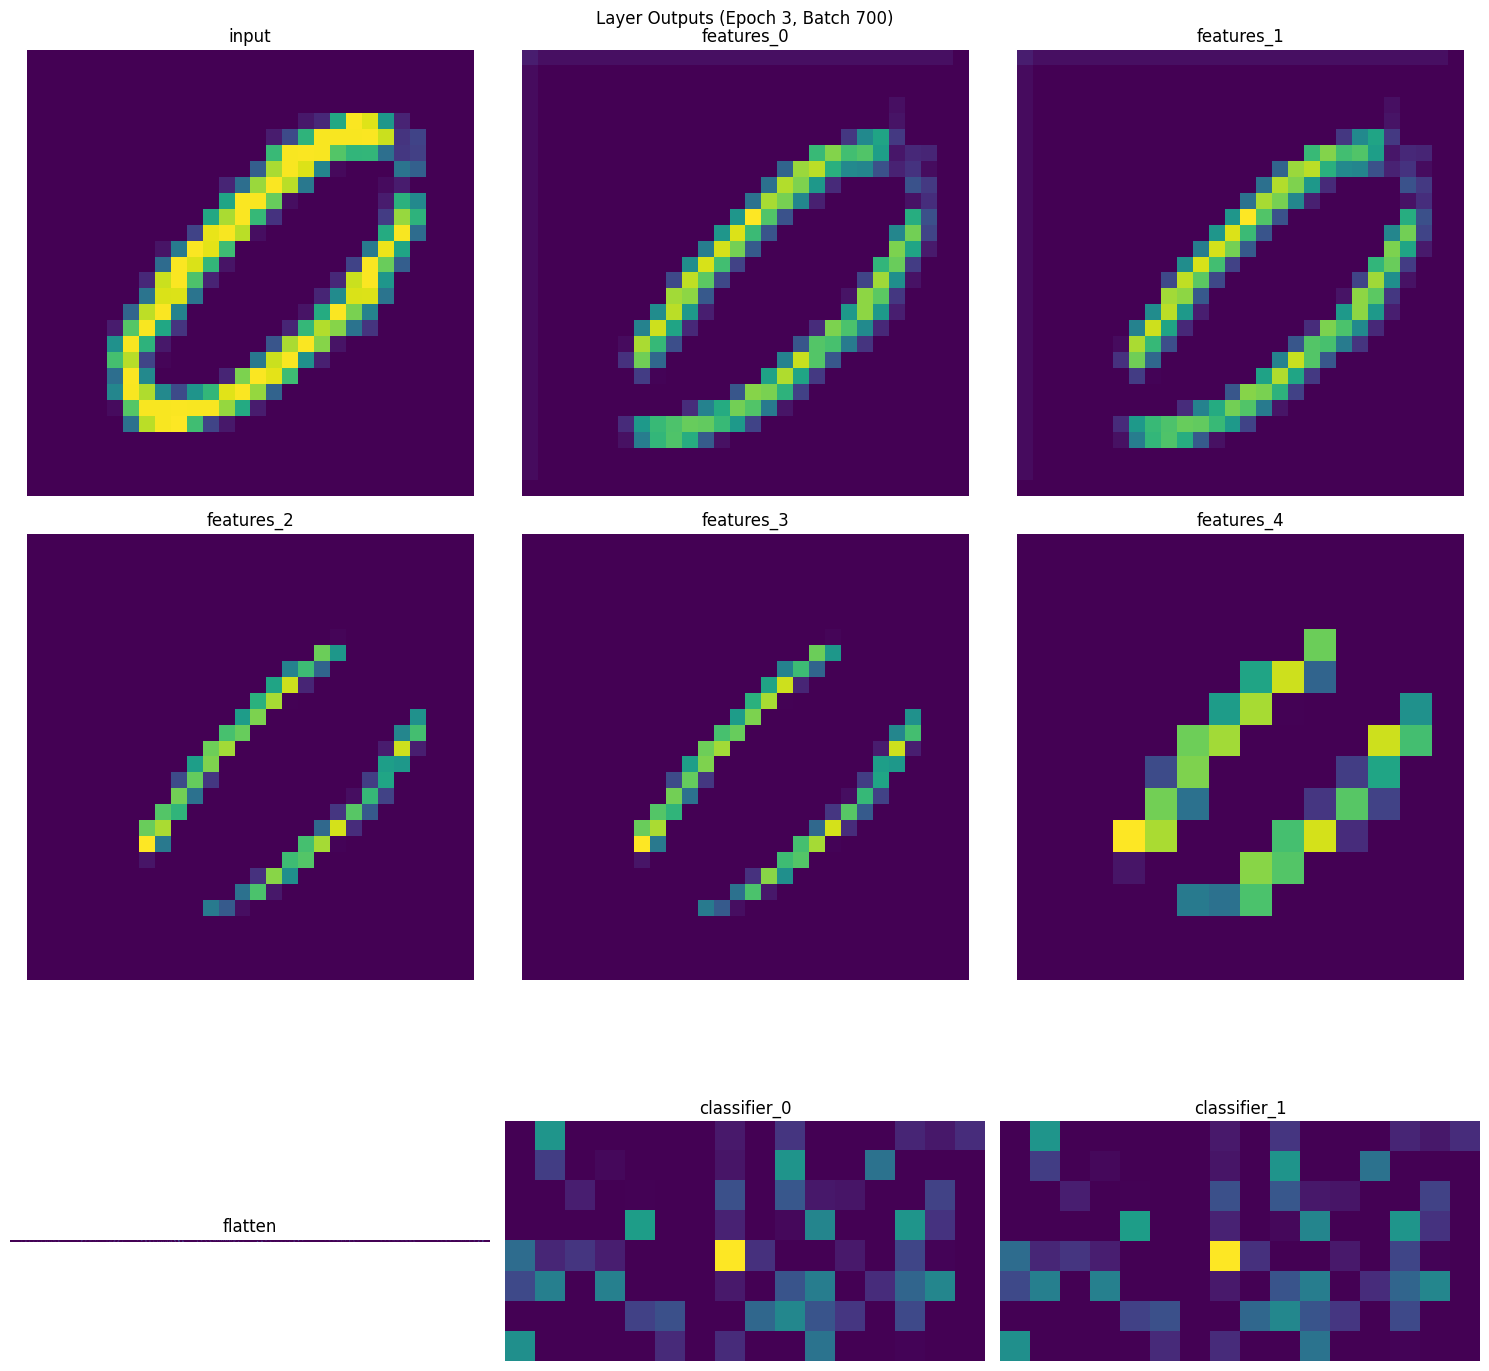


Analyzing pcoder layers:
Epoch 3/5, Batch 800/938, Loss: 0.0014


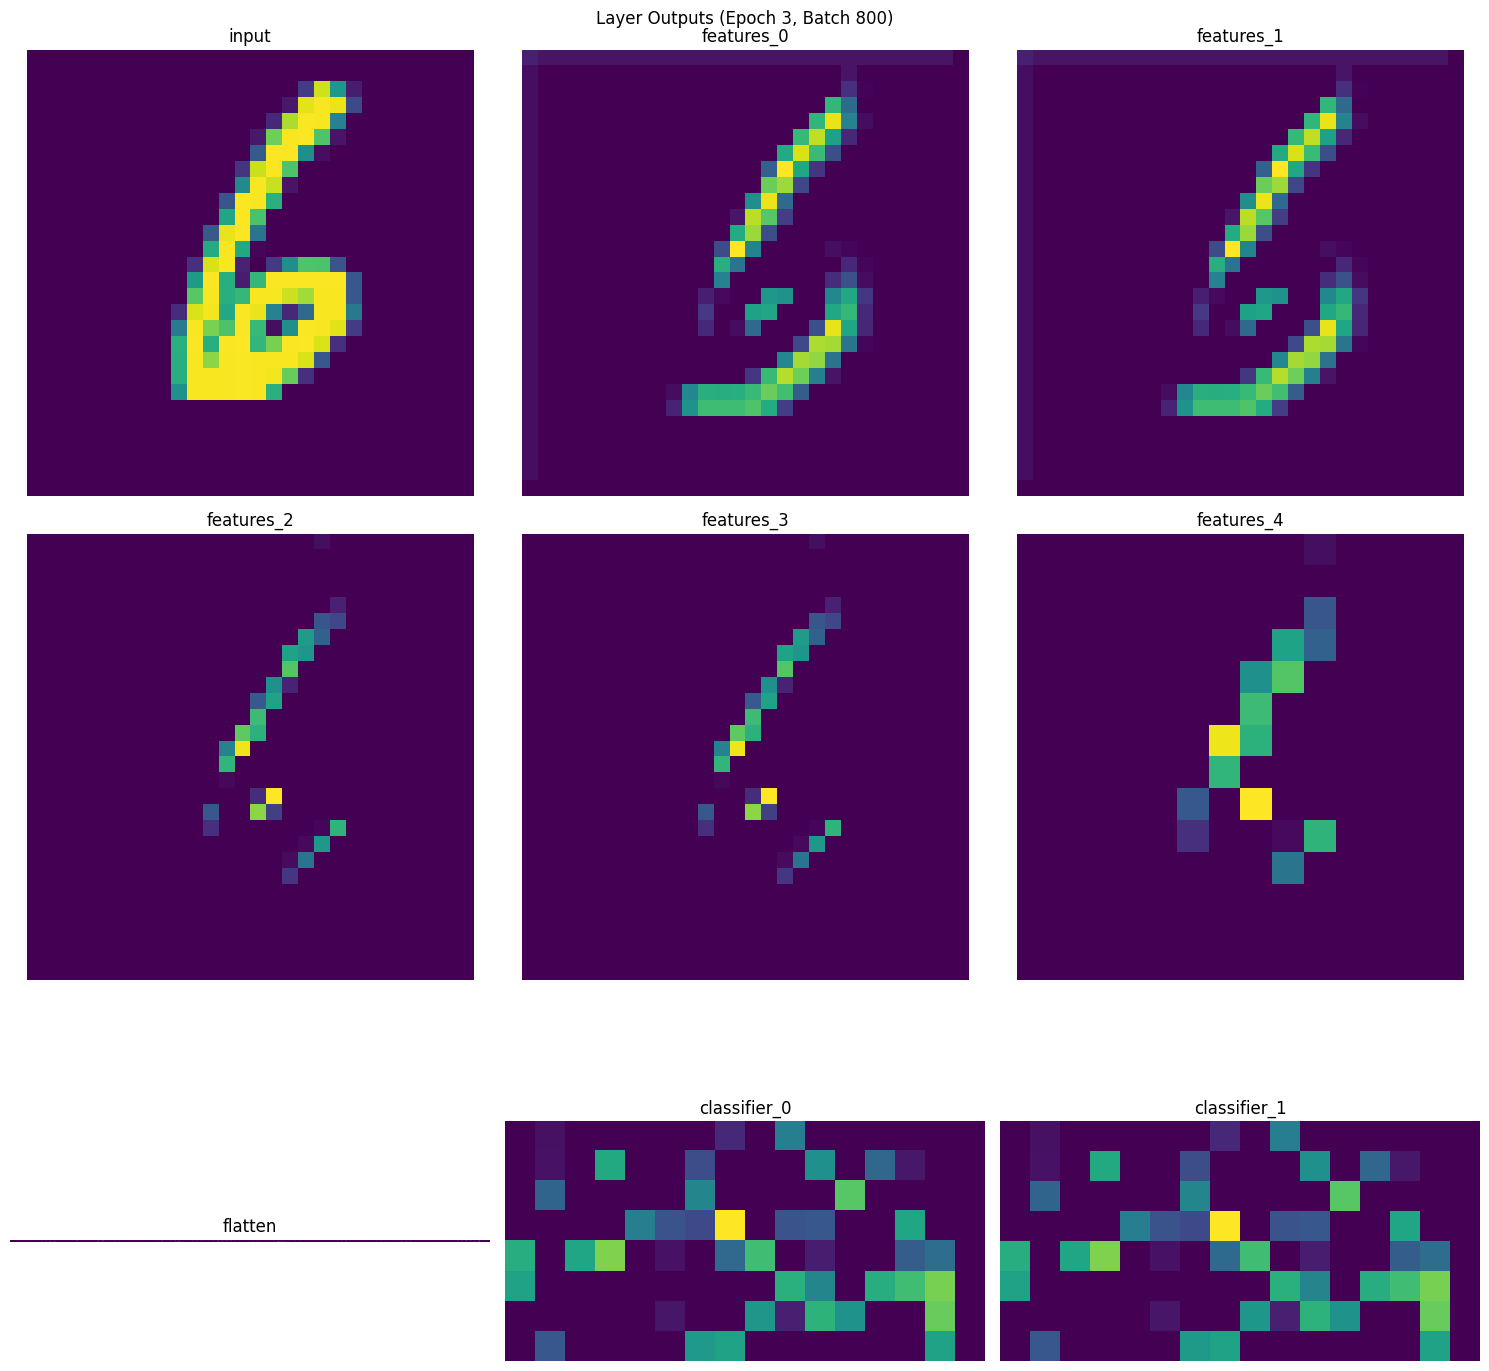


Analyzing pcoder layers:
Epoch 3/5, Batch 900/938, Loss: 0.0316


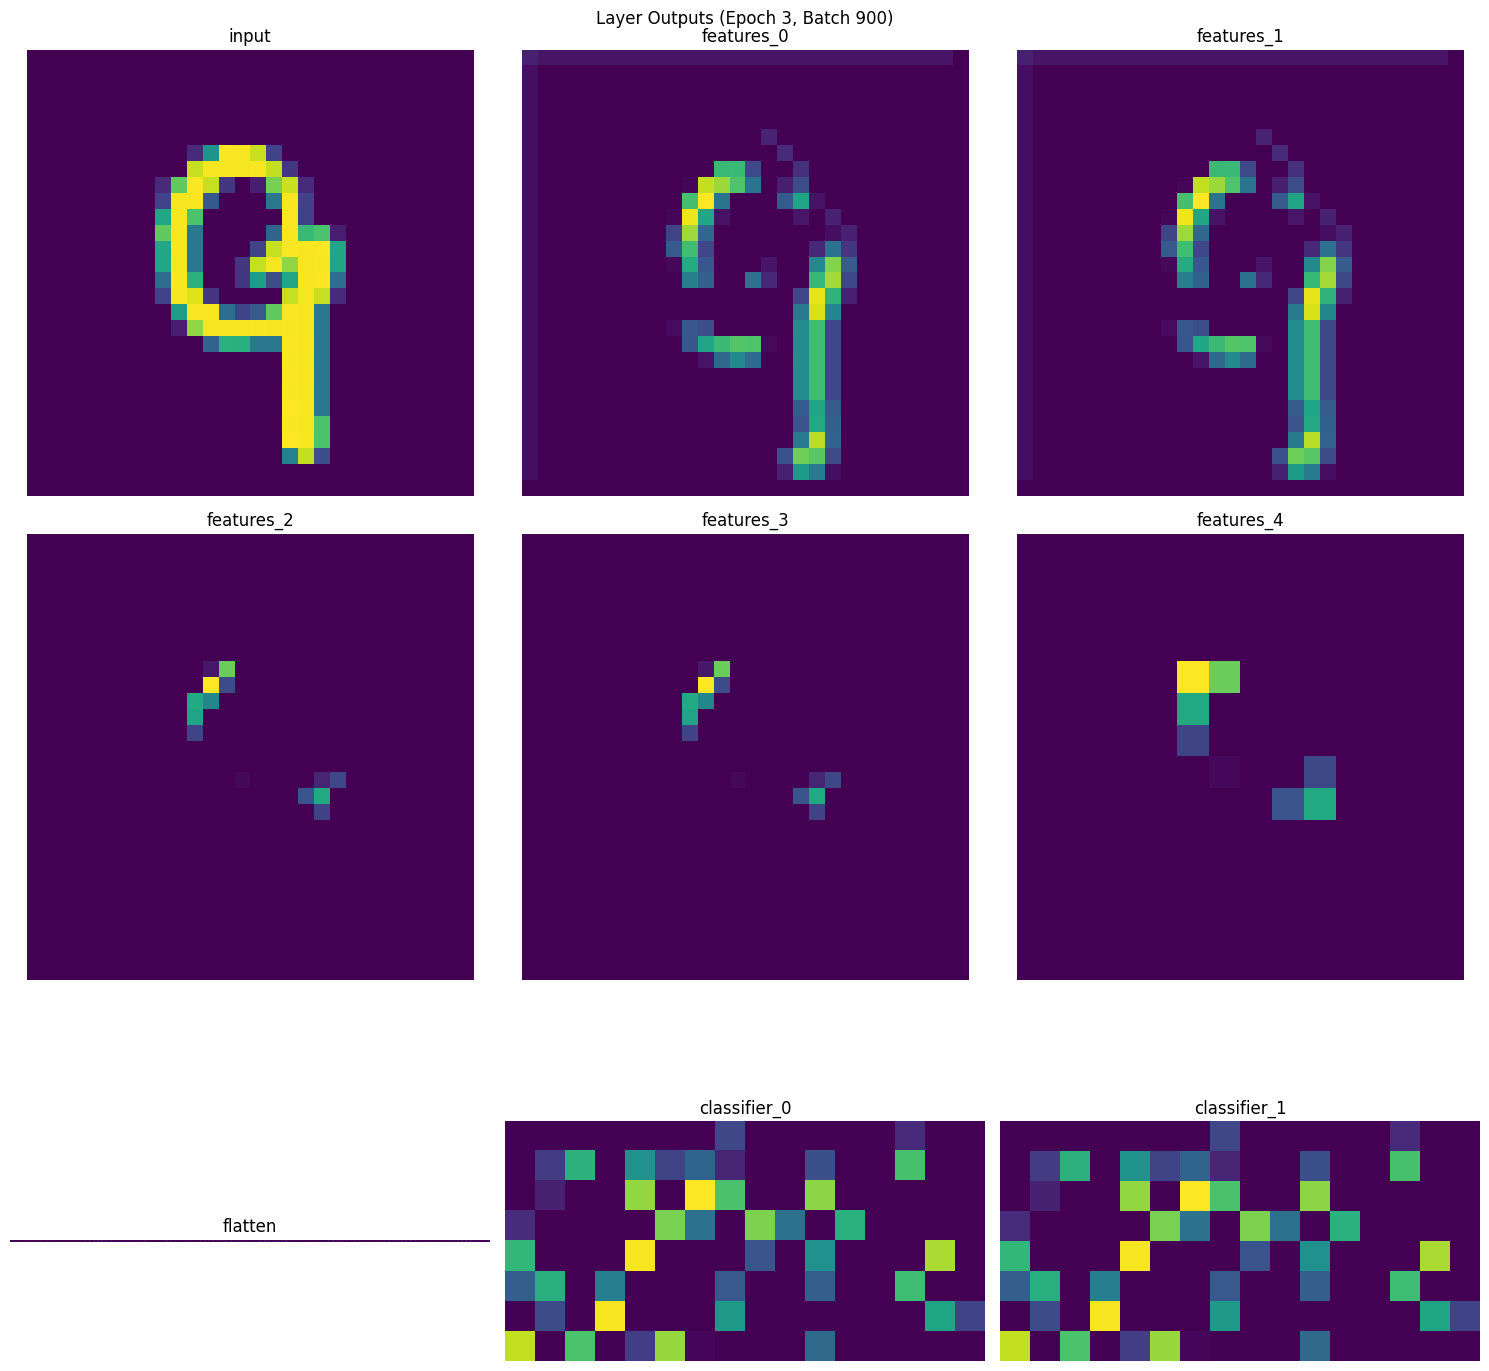


Analyzing pcoder layers:
Epoch 4/5, Batch 0/938, Loss: 0.0009


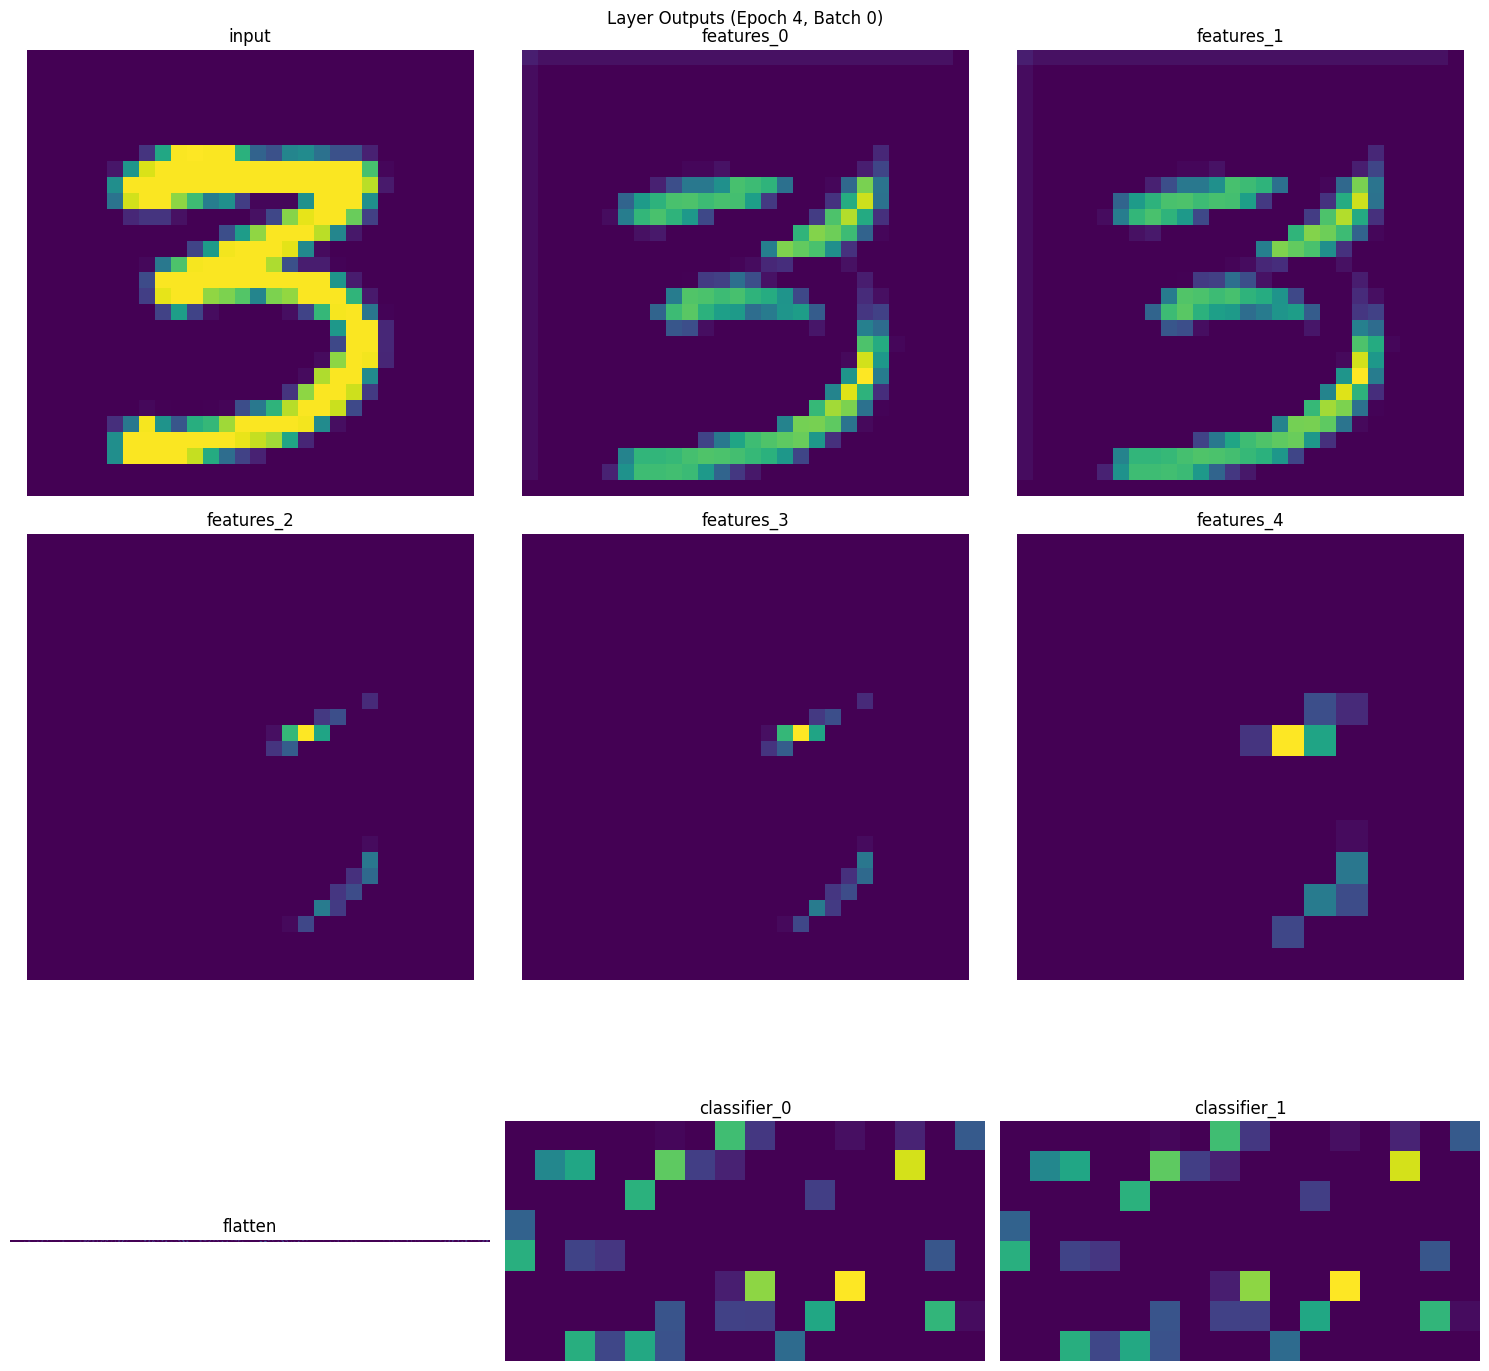


Analyzing pcoder layers:
Epoch 4/5, Batch 100/938, Loss: 0.0016


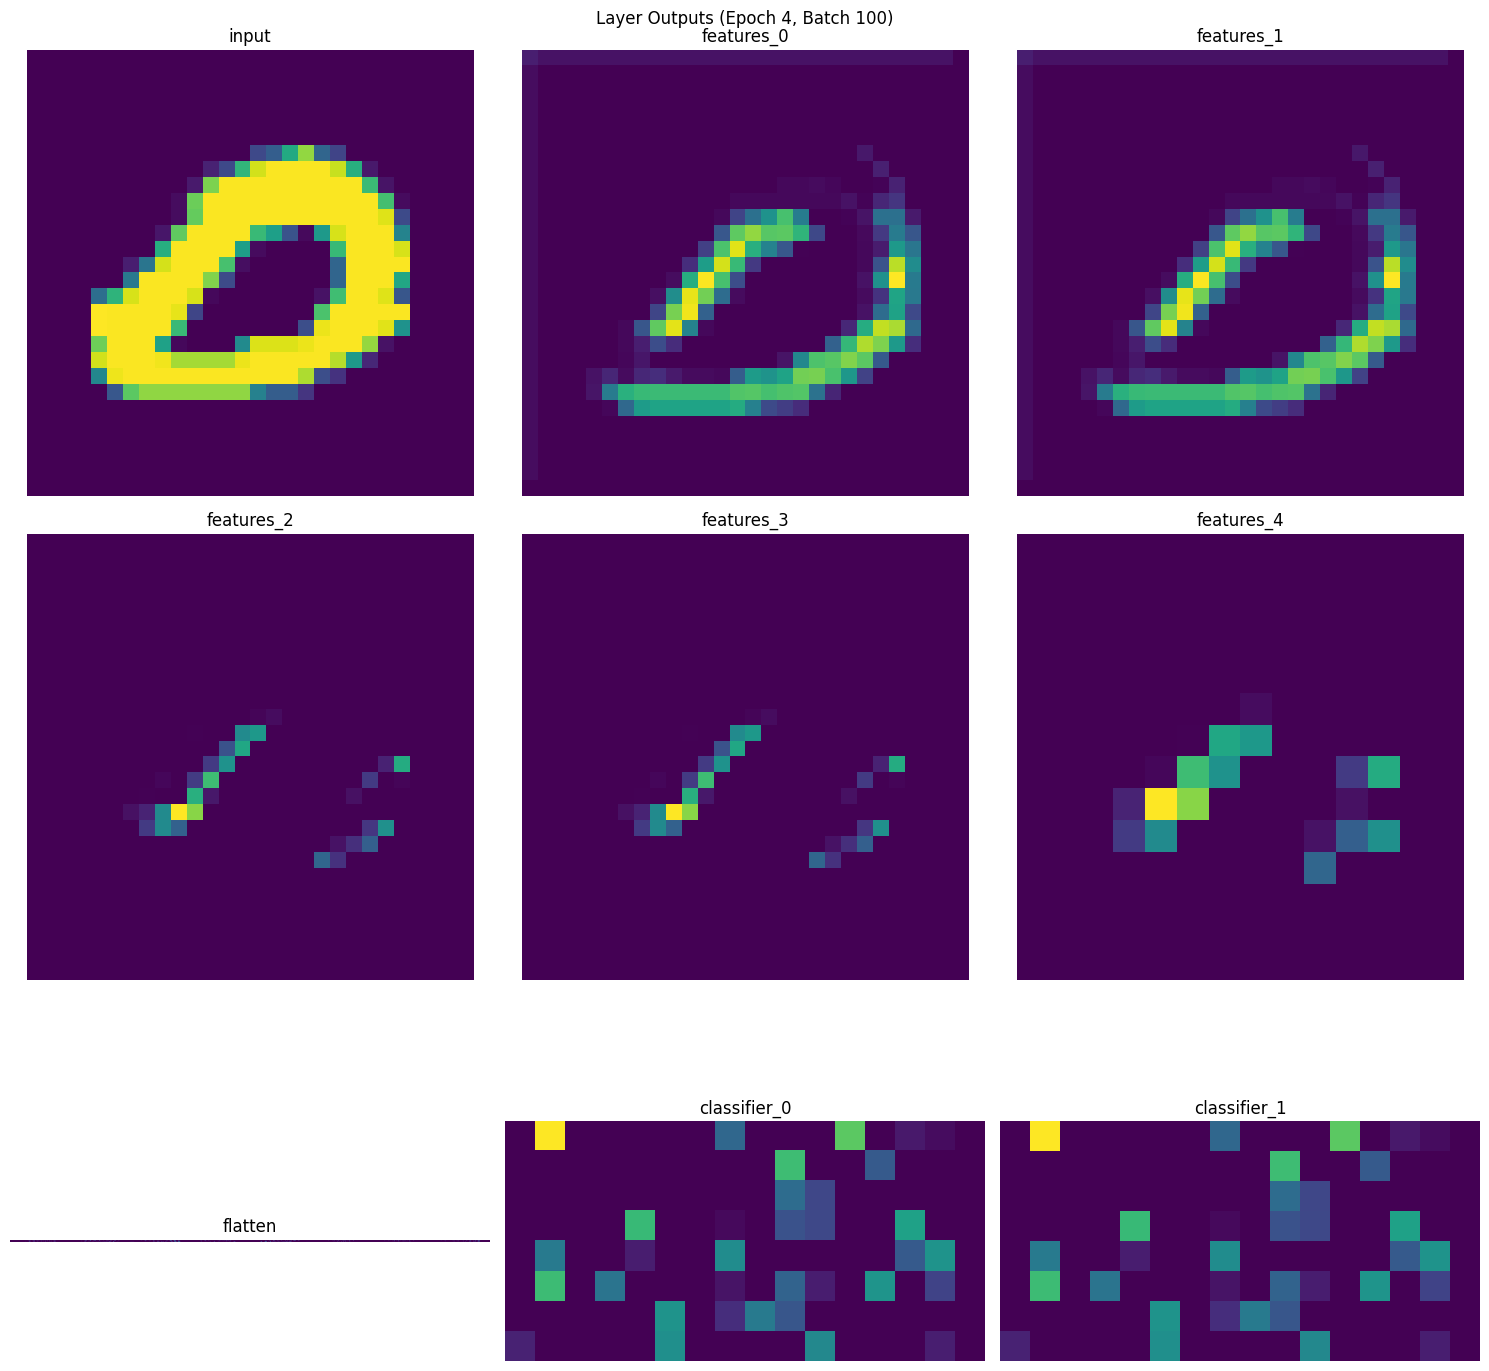


Analyzing pcoder layers:


In [ ]:
!pip install git+https://github.com/miladmozafari/predify.git
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from predify import predify
import matplotlib.pyplot as plt

# Define a basic CNN for MNIST with hooks for layer analysis
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 10)
        )

        self.layer_outputs = {}

    def forward(self, x):
        self.layer_outputs['input'] = x

        for i, layer in enumerate(self.features):
            x = layer(x)
            self.layer_outputs[f'features_{i}'] = x

        x = torch.flatten(x, 1)
        self.layer_outputs['flatten'] = x

        for i, layer in enumerate(self.classifier):
            x = layer(x)
            self.layer_outputs[f'classifier_{i}'] = x

        return x

# Function to print model architecture and layer information
def print_model_info(model):
    print("Model Architecture:")
    print(model)
    print("\nLayer Information:")

    def get_layer_info(module, input_shape):
        try:
            with torch.no_grad():
                input = torch.randn(1, *input_shape).to(next(module.parameters()).device)
                output = module(input)
            return input.shape[1:], output.shape[1:]
        except:
            return input_shape, "Unknown"

    input_shape = (1, 28, 28)  # MNIST input shape
    for name, layer in model.named_modules():
        if isinstance(layer, (nn.Conv2d, nn.Linear, nn.ReLU, nn.MaxPool2d)):
            input_shape, output_shape = get_layer_info(layer, input_shape)
            print(f"{name}:")
            print(f"  Type: {type(layer).__name__}")
            print(f"  Input shape: {input_shape}")
            print(f"  Output shape: {output_shape}")
            input_shape = output_shape if isinstance(output_shape, tuple) else input_shape

# Function to visualize layer outputs
def visualize_layer_outputs(layer_outputs, epoch, batch_idx):
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle(f'Layer Outputs (Epoch {epoch+1}, Batch {batch_idx})')

    for i, (name, output) in enumerate(layer_outputs.items()):
        if i >= 9:  # Limit to 9 subplots
            break
        ax = axs[i // 3, i % 3]
        if output.dim() == 4:  # Conv layer output
            ax.imshow(output[0, 0].cpu().detach().numpy(), cmap='viridis')
        elif output.dim() == 2:  # Linear layer output
            ax.imshow(output[0].cpu().detach().numpy().reshape(8, -1), cmap='viridis')
        ax.set_title(name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Function to analyze pcoder layers
def analyze_pcoders(model, data):
    print("\nAnalyzing pcoder layers:")
    for name, module in model.named_modules():
        if hasattr(module, 'predictor'):
            print(f"\nPCoder layer: {name}")

            # Forward pass
            model(data)

            # Get the actual output and the predicted output
            actual_output = module.output
            predicted_output = module.predictor(actual_output)

            # Calculate prediction error
            prediction_error = torch.mean((actual_output - predicted_output) ** 2).item()

            print(f"Prediction error: {prediction_error:.6f}")

            # Visualize actual and predicted outputs
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
            ax1.imshow(actual_output[0, 0].cpu().detach().numpy(), cmap='viridis')
            ax1.set_title("Actual Output")
            ax1.axis('off')
            ax2.imshow(predicted_output[0, 0].cpu().detach().numpy(), cmap='viridis')
            ax2.set_title("Predicted Output")
            ax2.axis('off')
            plt.show()

# Set up data loaders
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BasicCNN().to(device)

# Print initial model information
print("Initial Model Information:")
print_model_info(model)

# Create a config file for Predify
config = """
name = "PredictiveMNIST"
input_size = [1, 28, 28]
gradient_scaling = true
shared_hyperparameters = false

[[pcoders]]
module = "features[1]"
predictor = "ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))"
hyperparameters = {feedforward=0.3, feedback=0.3, pc=0.01}

[[pcoders]]
module = "features[3]"
predictor = "ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))"
hyperparameters = {feedforward=0.3, feedback=0.3, pc=0.01}
"""

# Save the config to a file
with open('mnist_config.toml', 'w') as f:
    f.write(config)

# Apply Predify to the model
predify(model, 'mnist_config.toml')

# Print updated model information after applying Predify
print("\nModel information after applying Predify:")
print_model_info(model)

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
def train(epochs):
    for epoch in range(epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
                visualize_layer_outputs(model.layer_outputs, epoch, batch_idx)
                analyze_pcoders(model, data)

# Evaluation function
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

# Train and evaluate the model
train(epochs=5)
test()